In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sta
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score , mean_absolute_error , mean_squared_error
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.regressionplots import influence_plot
import statsmodels.api as sa
import statsmodels.formula.api as sfa
import statsmodels as st
import pickle as pkl
import os
plt.rcParams['figure.figsize'] = (12,5)
sns.set_theme(style='darkgrid',palette='viridis')
model_save_path = './Deployment/model'

In [2]:
df = pd.read_csv('./temperature_data.csv')
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


# EDA

The data set is collected from several sensors from permanent magnet synchronous motor deployed on test bench.

* All recordings are sampled at 2 Hz. i.e 2 cycles / second.
* The motor is excited by hand-designed driving cycles denoting a reference motor speed and a reference torque. 
* Currents in d/q-coordinates (columns "i_d" and i_q") and voltages in d/q-coordinates (columns "u_d" and "u_q") are a result of a standard control strategy trying to follow the reference speed and torque. 
* Columns "motor_speed" and "torque" are the resulting quantities achieved by that strategy, derived from set currents and voltages.

**In permanent magnet synchronous motor the rotor contains permanent magnets, while the stator consists of windings that generate a rotating magnetic field when energized.**

In [3]:
df.isna().any()

ambient           False
coolant           False
u_d               False
u_q               False
motor_speed       False
torque            False
i_d               False
i_q               False
pm                False
stator_yoke       False
stator_tooth      False
stator_winding    False
profile_id        False
dtype: bool

In [4]:
df.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


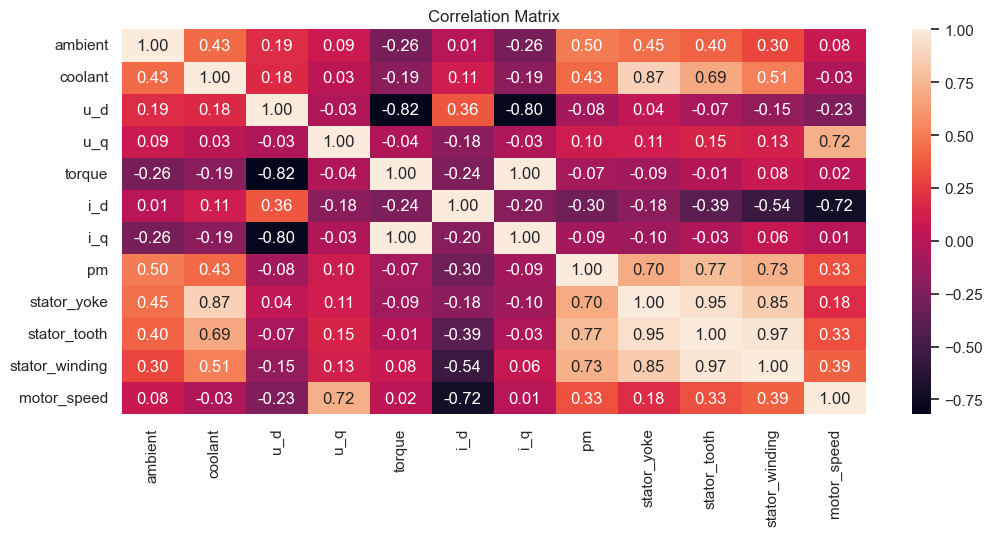

In [5]:
sns.heatmap(df[['ambient', 'coolant', 'u_d', 'u_q', 'torque', 'i_d',
       'i_q', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding', 'motor_speed']].corr(),annot=True,fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

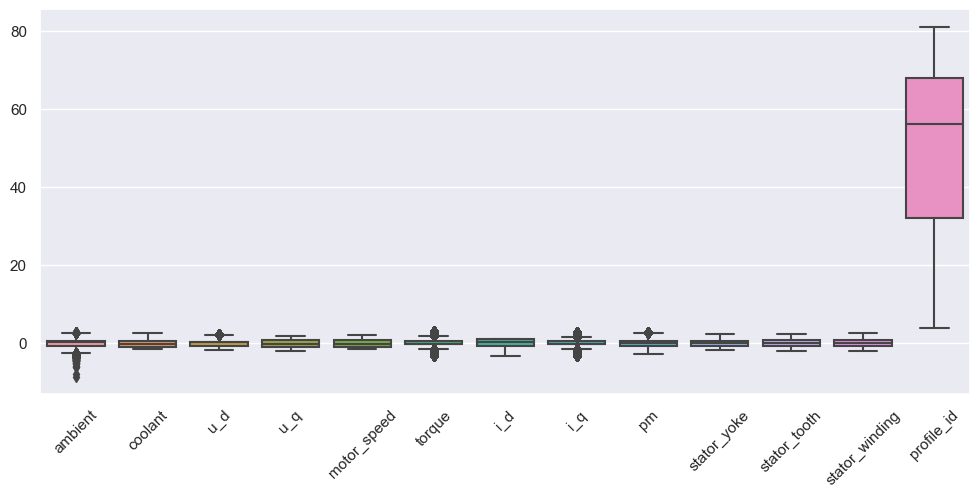

In [6]:
sns.boxplot(df)
plt.xticks(rotation=45)
plt.show()

*Outiers Observed in ambient , u_d , torque , i_q , pm independent Features*

## Handeling outliers

In [7]:
outlier_cols = ['ambient','u_d','torque','i_q','pm']

In [8]:
len_df = len(df)

In [9]:
def get_outlier_range(col,df):
    q_1 = df[col].quantile(0.25)
    q_3 = df[col].quantile(0.75)
    iqr = q_3 - q_1
    upper_bound = q_3 + (1.5 * iqr)
    lower_bound = q_1 - (1.5 * iqr)
    return (upper_bound,lower_bound)

In [10]:
for i in outlier_cols:
    upperbound,lowerbound = get_outlier_range(i,df)
    df.loc[df[i]>upperbound,i] = upperbound 
    df.loc[df[i]<lowerbound,i] = lowerbound
    
    

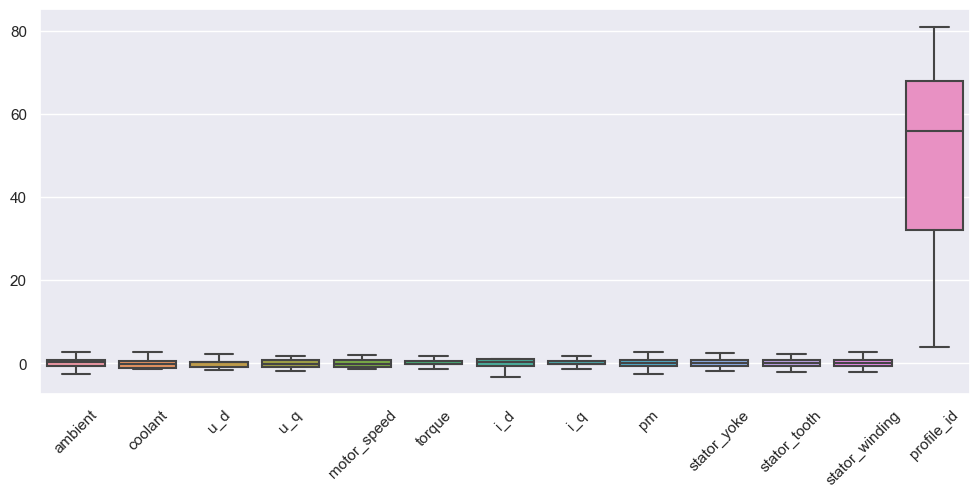

In [11]:
sns.boxplot(df)
plt.xticks(rotation=45)
plt.show()

# Important Keywords and What they means

## Losses

* **Copper Losses:** Copper losses occur due to the resistance of the motor windings. These losses consist of both the stator and rotor copper losses. Stator copper losses result from the current flowing through the stator windings, while rotor copper losses occur due to the current passing through the rotor windings. Copper losses are influenced by the current magnitude and the resistance of the winding materials.
* **Iron Core Losses:** Iron core losses, also known as core losses or magnetic losses, are losses that occur in the motor's magnetic core. They can be further divided into two types:
    * **Hysteresis Loss:** Hysteresis loss occurs due to the reversal of magnetization in the motor's core material as the magnetic field changes direction. This loss is influenced by the material properties of the core, including its magnetic characteristics and frequency of operation.
    *  **Eddy Current Loss:** Eddy current loss arises from the circulating currents induced within the core material by the changing magnetic field. These currents generate heat and result in power dissipation. The magnitude of eddy current losses depends on the core material's electrical conductivity, the thickness of the laminations, and the operating frequency.


## Operational Terms

* **Field weakening operation** in a Permanent Magnet Synchronous Motor (PMSM) refers to the control strategy used to operate the motor at speeds higher than its base or rated speed. The base speed is typically limited by the maximum voltage and current that can be supplied to the motor while maintaining the magnetic field within the permanent magnets. By implementing field weakening, the motor's speed can be extended beyond its rated speed range.During field weakening, the stator current is controlled in a way that intentionally weakens the magnetic field produced by the permanent magnets. This allows the motor to operate at higher speeds by reducing the magnetic flux linkage and adjusting the motor's torque-speed characteristics.The field weakening operation is typically achieved by controlling the d-axis current (also known as the magnetizing current) and q-axis current (also known as the torque-producing current) of the motor. By reducing the d-axis current and increasing the q-axis current, the balance between the magnetizing and torque-producing components of the current can be altered.
* **Field-Oriented Control (FOC)**, also known as Vector Control, is a control technique used in Permanent Magnet Synchronous Motors (PMSMs) to achieve precise control over motor speed and torque. FOC allows decoupled control of the motor's magnetizing flux and torque-producing current components, enabling efficient and accurate motor control.

## Profile ID

The dataset consists of multiple measurement sessions, which can be distinguished from each other by this column.

A measurement session can be between one and six hours long.

In [12]:
# session counts
print(f"Total Measurement session : {len(df['profile_id'].unique())}")

Total Measurement session : 52


In [13]:
print(f"Unique Sessions ID : {df['profile_id'].unique()}")

Unique Sessions ID : [ 4  6 10 11 20 27 29 30 31 32 36 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 73 74 75 76 77 78
 79 80 81 72]


In [14]:
session_df = {'profile_id':[],'session_data_count':[]}
for i in df['profile_id'].unique():
    session_df['profile_id'].append(i)
    session_df['session_data_count'].append(len(df[df['profile_id']==i]))
session_df = pd.DataFrame(session_df)


In [15]:
session_df['Session_length (sec)'] = session_df['session_data_count'].apply(lambda x : x/2)
session_df['Session_length (min)'] = session_df['Session_length (sec)'].apply(lambda x :round(x/60,2))
session_df['Session_length (hr)'] = session_df['Session_length (min)'].apply(lambda x : round(x/60,2))


In [16]:
session_df.sort_values('Session_length (hr)')

,profile_id,session_data_count,Session_length (sec),Session_length (min),Session_length (hr)
17,47,2175,1087.5,18.12,0.30
16,46,2179,1089.5,18.16,0.30
22,52,3725,1862.5,31.04,0.52
21,51,6260,3130.0,52.17,0.87
34,64,6249,3124.5,52.08,0.87
29,59,7474,3737.0,62.28,1.04
3,11,7886,3943.0,65.72,1.10
47,78,8444,4222.0,70.37,1.17
13,43,8442,4221.0,70.35,1.17
25,55,10806,5403.0,90.05,1.50


*There are 5 test sessions which lasted less than 1hr**

In [17]:
random_session = df[df['profile_id']==20]

# Annova

In [18]:
anova_sample_stat = {'Columns':[],'Anova_Pval':[]}
for i in df.columns[:-1]:
    f , p = sta.f_oneway(df[i],random_session[i])
    anova_sample_stat['Columns'].append(i)
    anova_sample_stat['Anova_Pval'].append(p)
sample_stat = pd.DataFrame(anova_sample_stat)    
sample_stat['Significant_difference'] = sample_stat['Anova_Pval'].apply(lambda x : True if x < 0.05 else False)
sample_stat

,Columns,Anova_Pval,Significant_difference
0,ambient,8.025038e-01,False
1,coolant,0.000000e+00,True
2,u_d,0.000000e+00,True
3,u_q,0.000000e+00,True
4,motor_speed,0.000000e+00,True
5,torque,0.000000e+00,True
6,i_d,1.194006e-168,True
7,i_q,0.000000e+00,True
8,pm,9.271427e-02,False
9,stator_yoke,0.000000e+00,True


## Ambient

Ambient temperature as measured by a thermal sensor located closely to the stator.

The excitation magnetic field is provided by permanent magnet therefore the performance of PMSM is highly dependent on the permanent magnet (PM) temperature.

Temperature affects magnetism by either strengthening or weakening a magnet’s attractive force. A magnet subjected to heat experiences a reduction in its magnetic field as the particles within the magnet are moving at an increasingly faster and more sporadic rate. This jumbling confuses and misaligns the magnetic domains, causing the magnetism to decrease.  Conversely, when the same magnet is exposed to low temperatures, its magnetic property is enhanced and the strength increases.

Since the magnetic property of permenant magnet is affected by the temperature, we measure the ambient temperature but we have temperature sensor near stator and in case of PMSM the permenant magnet is in the rotor there is some difference between the stator and rotor temperature.

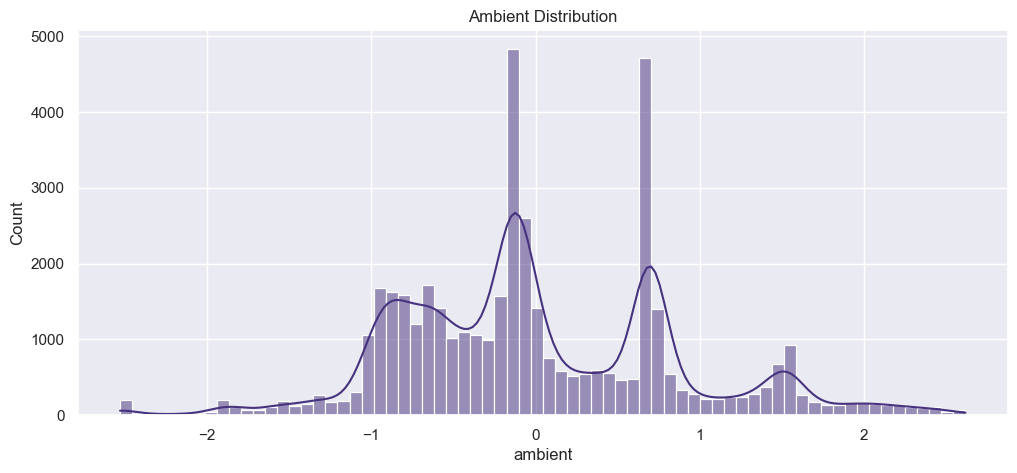

In [19]:
# lets visualize the data distribution of random session
sns.histplot(random_session['ambient'],kde=True)
plt.title('Ambient Distribution')
plt.show()

*As we observe multiple peaks the distribution is multimodal.*

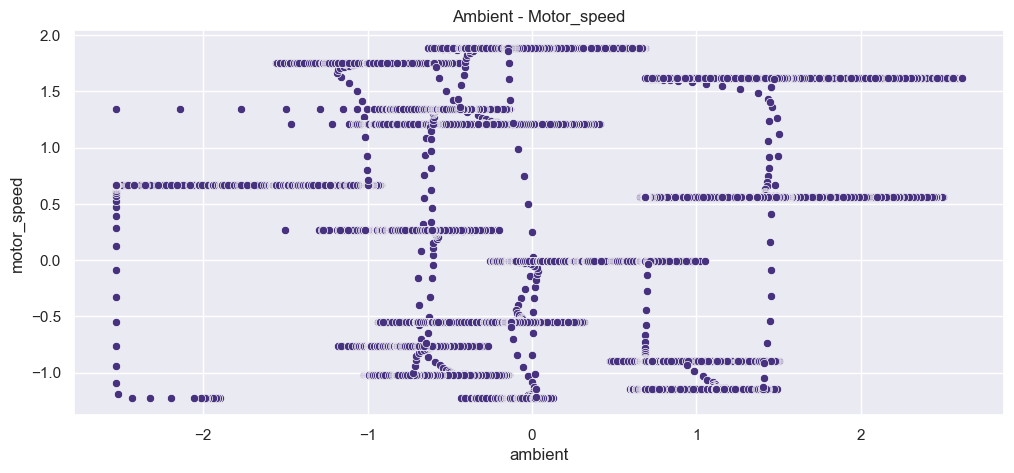

In [20]:
sns.scatterplot(x=random_session['ambient'],y=random_session['motor_speed'])
plt.title('Ambient - Motor_speed')
plt.show()

## Coolant

*The temperature rises due to electrical resistance from copper wire , also from the iron cores due to constant magnetization and de-magnetization and also from eddy currents and some other mechanical factor like friction.*

*To Control the temperatur we have some cooling solution like in our case we have coolant(water).*

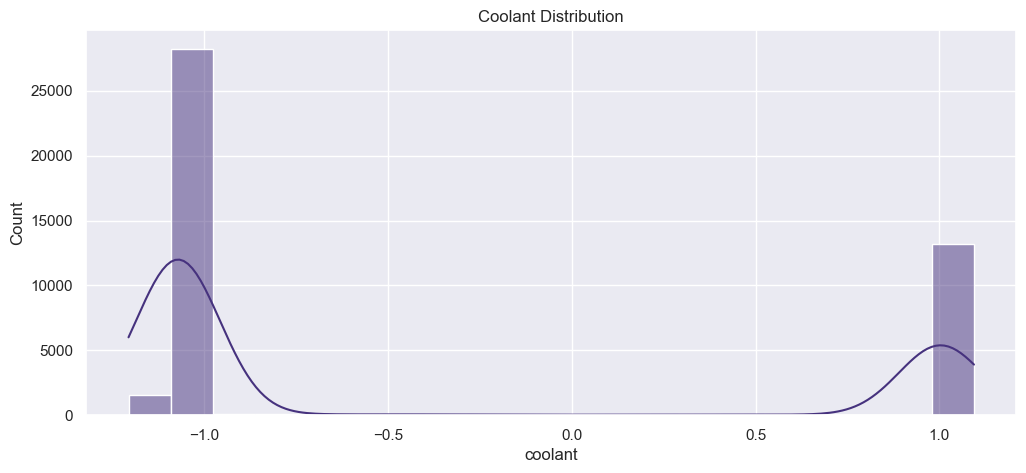

In [21]:
sns.histplot(random_session['coolant'],kde=True)
plt.title('Coolant Distribution')
plt.show()

*Since the coolant temperatures are calculated at the outflow this temperature tends to be higher than the ambient temperature due to heat transfer rate , thermal resistances and operating condition of motor.*

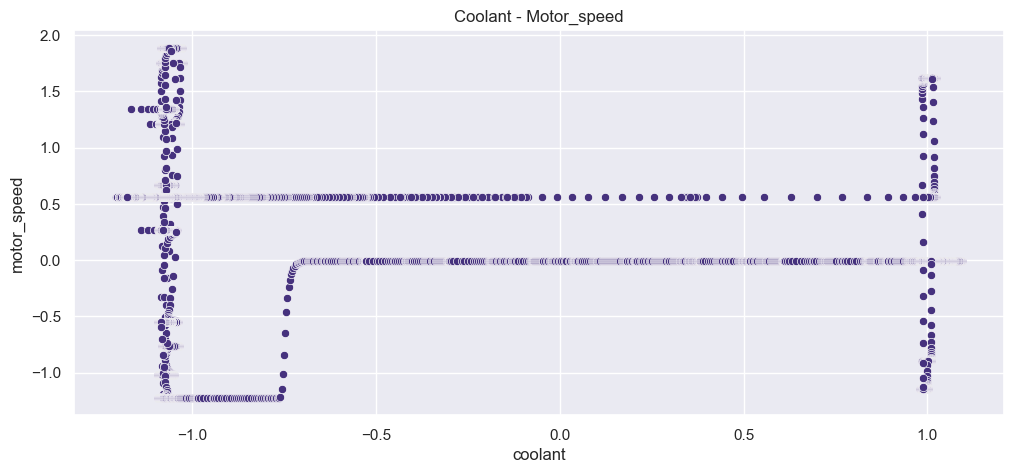

In [22]:
sns.scatterplot(x=random_session['coolant'],y=random_session['motor_speed'])
plt.title('Coolant - Motor_speed')
plt.show()

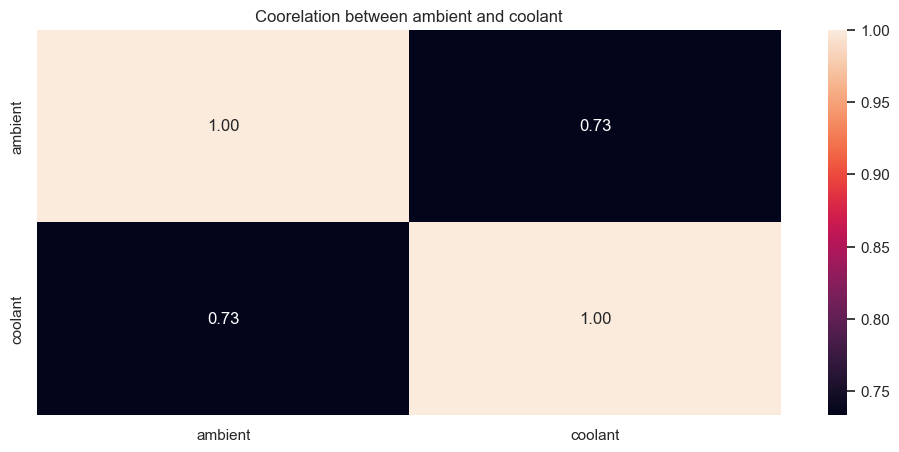

In [23]:
sns.heatmap(random_session[['ambient','coolant']].corr(),annot=True,fmt='.2f')
plt.title('Coorelation between ambient and coolant')
plt.show()

*Both show high correlation*

## u_d

In  permanent magnet synchronous motors we use 3-phase alternating current in stator to create Rotating Magnetic Field. The d-q component of voltage refers to the decomposition of a three-phase voltage signal into two orthogonal components: the d-axis component and the q-axis component.  

 This decomposition is commonly used in the analysis and control of three-phase electrical systems

The d-axis component represents the voltage component aligned with the rotor flux of the machine, also known as the direct-axis component. It influences the magnetization level or the magnetic flux in the motor.**It is responsible for controlling the direct-axis (d-axis) current, which determines the strength of the magnetic field generated by the permanent magnets**.

***The Major use of d-component of voltage is to control magnetization by controling the current***

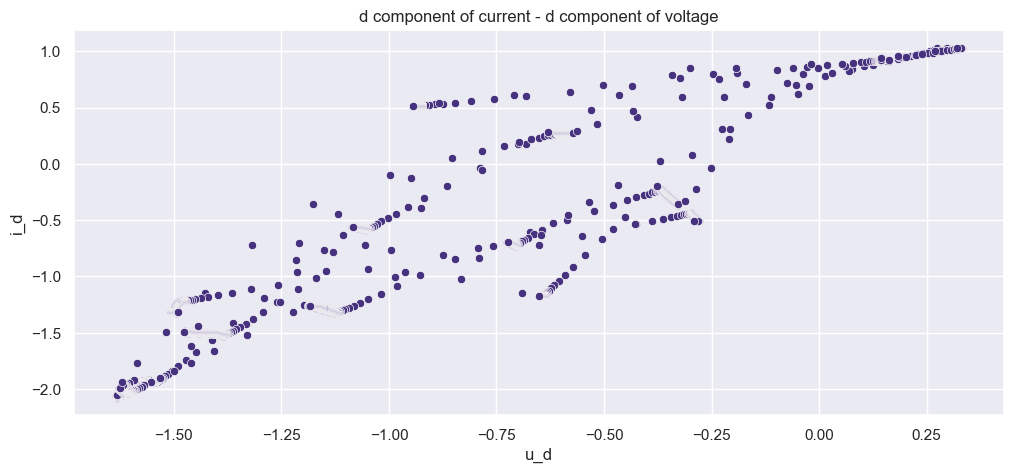

In [24]:
sns.scatterplot(x=random_session['u_d'],y=random_session['i_d'])
plt.title('d component of current - d component of voltage')
plt.show()

*Shows Somewhat linear relationship*

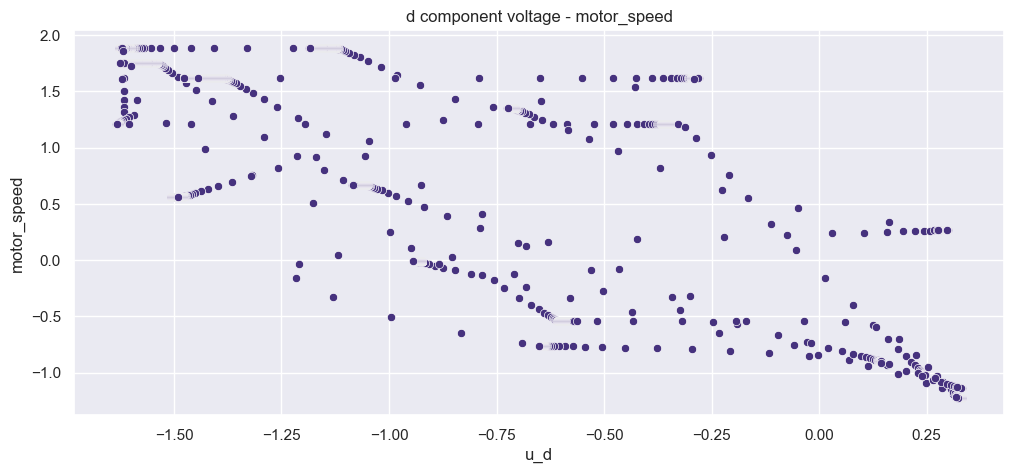

In [25]:
sns.scatterplot(x=random_session['u_d'],y=random_session['motor_speed'])
plt.title('d component voltage - motor_speed')
plt.show()

## u_q

The q-component of voltage in a Permanent Magnet Synchronous Motor (PMSM) influences the torque production of the motor. **It is responsible for controlling the quadrature-axis (q-axis) current, which is the current flowing through the motor's q-axis.**

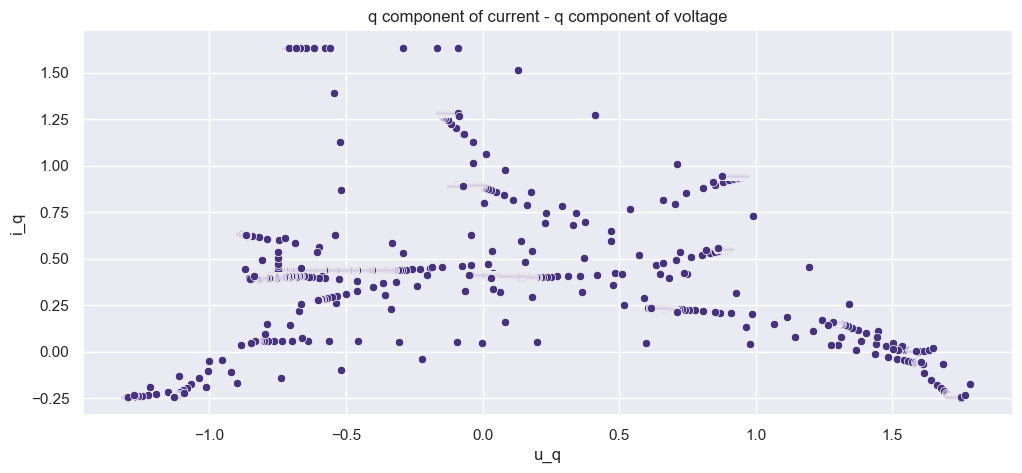

In [26]:
sns.scatterplot(x=random_session['u_q'],y=random_session['i_q'])
plt.title('q component of current - q component of voltage')
plt.show()

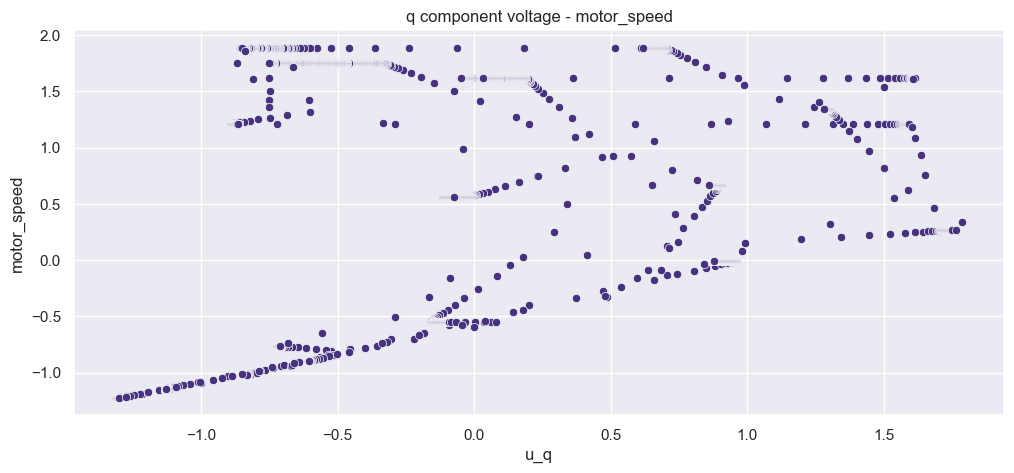

In [27]:
sns.scatterplot(x=random_session['u_q'],y=random_session['motor_speed'])
plt.title('q component voltage - motor_speed')
plt.show()

## Torque

Torque refers to the rotational force produced by the motor. It is the force that causes the motor to rotate or apply a twisting action to a mechanical load.

The torque in a PMSM is primarily influenced by the following factors: <br>
* Current: The magnitude of the current flowing through the motor windings, particularly the q-axis current, directly affects the torque production. A higher current results in a stronger magnetic field and, consequently, a higher torque output.
* Magnetic Field Strength: The strength of the magnetic field generated by the permanent magnets in the rotor directly influences the torque. The stronger the magnetic field, the higher the torque output.
* Flux Linkage: The flux linkage, which represents the interaction between the rotor magnetic field and the stator windings, affects the torque production. The higher the flux linkage, the higher the torque output.
* Temperature: The temperature of the motor can affect the torque output. High temperatures can lead to increased resistive losses and reduced magnetic properties of the motor, potentially impacting torque production.

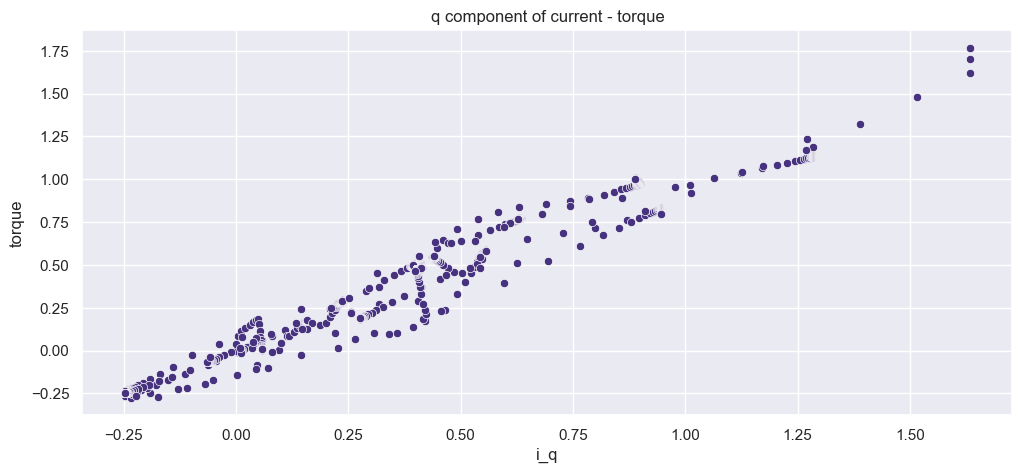

In [28]:
sns.scatterplot(x=random_session['i_q'],y=random_session['torque'])
plt.title('q component of current - torque')
plt.show()

*Linear Upward trend observed*

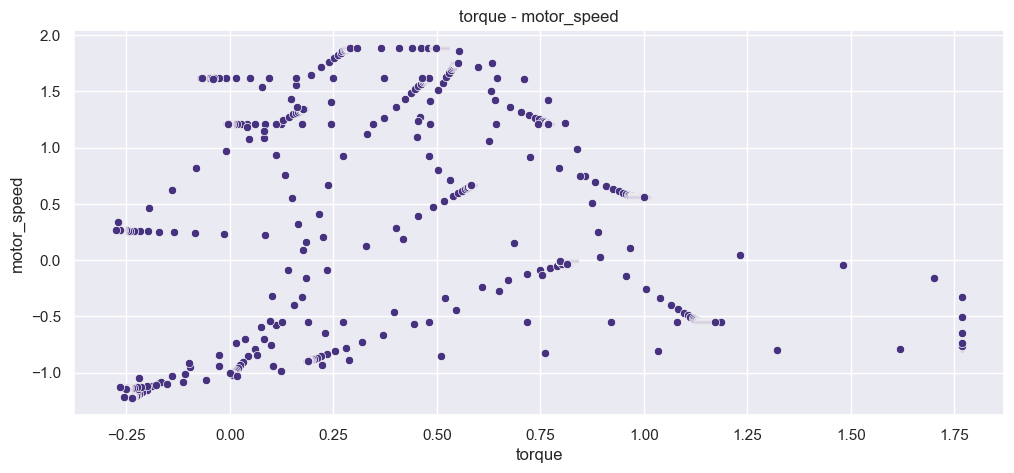

In [29]:
sns.scatterplot(x=random_session['torque'],y=random_session['motor_speed'])
plt.title('torque - motor_speed')
plt.show()

*Inverse Relationship between torque and angular speed*

*The constant torque for many ambient temp might be due to many reasons such as effective cooling and other operational optimizations*

## i_d

In a Permanent Magnet Synchronous Motor (PMSM), the d-component of AC current refers to the component of the current that flows along the direct axis (d-axis) of the motor. The d-axis is a reference axis aligned with the magnetic field produced by the permanent magnets in the rotor.

The d-component of current is responsible for controlling the magnetic field strength and alignment in the motor. It influences the flux linkage and ensures that the magnetic field is properly aligned with the rotor's magnetic field, optimizing torque production and motor efficiency.

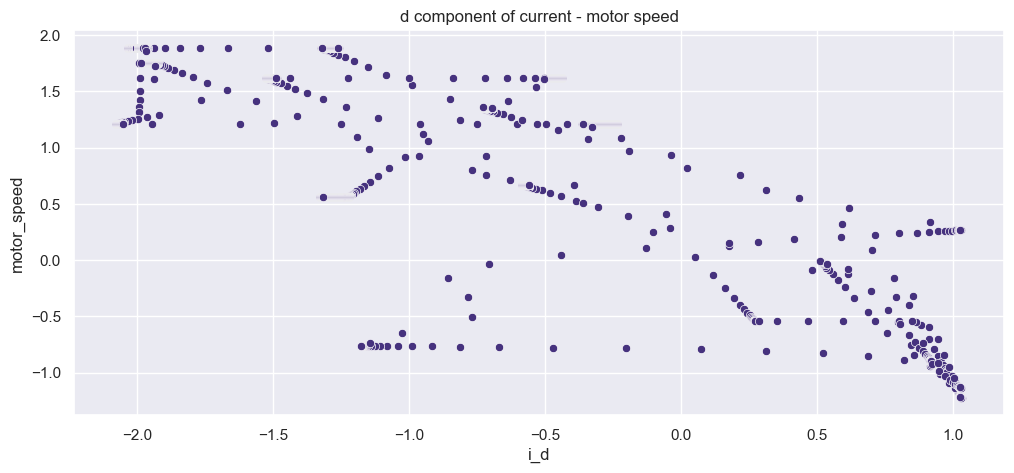

In [30]:
sns.scatterplot(x=random_session['i_d'],y=random_session['motor_speed'])
plt.title('d component of current - motor speed')
plt.show()

## i_q

In a Permanent Magnet Synchronous Motor (PMSM), the q-component of AC current refers to the component of the current that flows along the quadrature axis (q-axis) of the motor. The q-axis is perpendicular to the d-axis, which is aligned with the magnetic field produced by the permanent magnets in the rotor.

The q-component of current is responsible for controlling the torque production in the motor. It generates the magnetic field that interacts with the rotor's magnetic field, resulting in the production of torque.

**Increasing the q-component results in higher torque, while reducing it decreases the torque output.** This allows for precise control over the motor's torque production and the ability to vary the torque according to the desired application requirements.

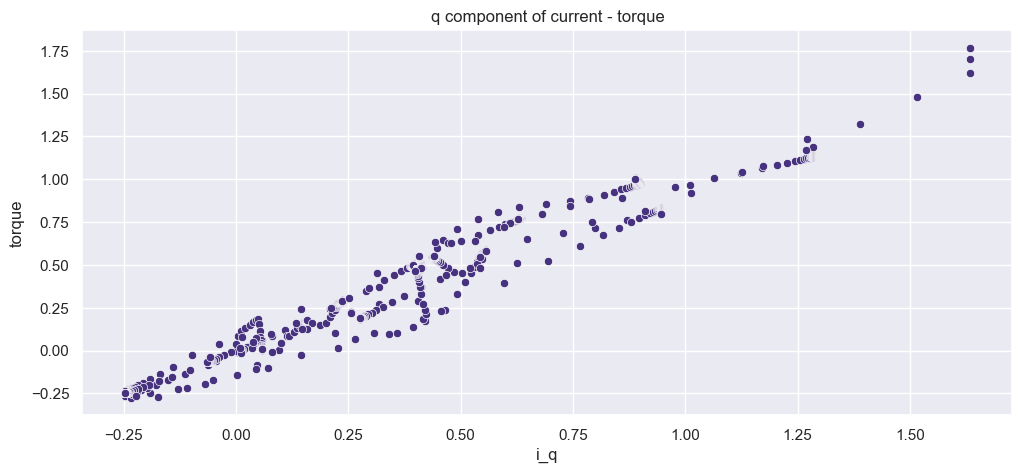

In [31]:
sns.scatterplot(x=random_session['i_q'],y=random_session['torque'])
plt.title('q component of current - torque')
plt.show()

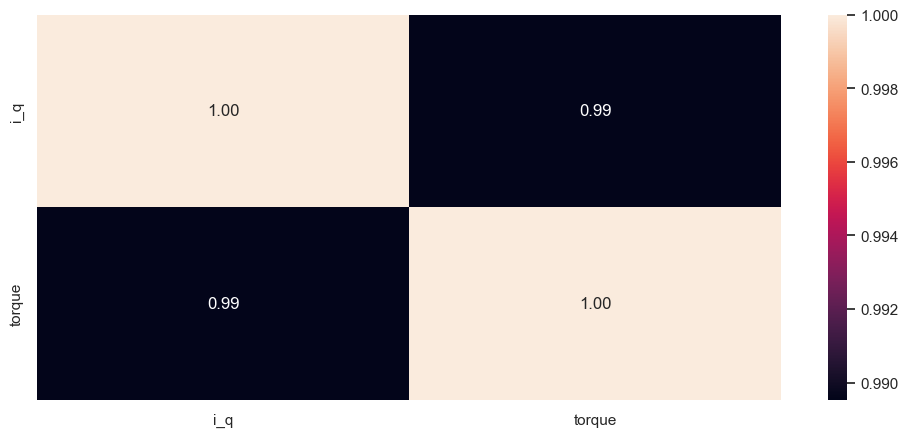

In [32]:
sns.heatmap(random_session[['i_q','torque']].corr(),annot=True,fmt='.2f')
plt.show()

*Observed High correlation*

## pm

Permanent Magnet surface temperature representing the rotor temperature. This was measured with an infrared thermography unit.

Some effects of permanent magnet surface temperature on PMSM: <br>
* Magnetic Properties: The strength of permanent magnets is influenced by temperature. Generally, as the temperature of the magnets increases, their magnetic properties, such as remanence (residual magnetization) and coercivity (ability to resist demagnetization), can change. Higher temperatures can lead to a decrease in magnetic strength, resulting in reduced motor performance.
* Demagnetization: Excessive heat can cause permanent magnets to demagnetize. If the surface temperature of the magnets exceeds their Curie temperature, the magnets may lose their magnetic properties altogether, resulting in a significant reduction in motor torque and efficiency.
* Torque Output: As the temperature of the permanent magnets increases, the torque output of the motor may decrease. This is because the weakening magnetic field affects the interaction between the rotor and stator, leading to a reduction in torque production.
* Efficiency: Higher permanent magnet temperatures can result in increased losses within the motor, including core losses, copper losses, and additional losses due to increased resistance in the windings. These losses can reduce the overall efficiency of the motor.
    

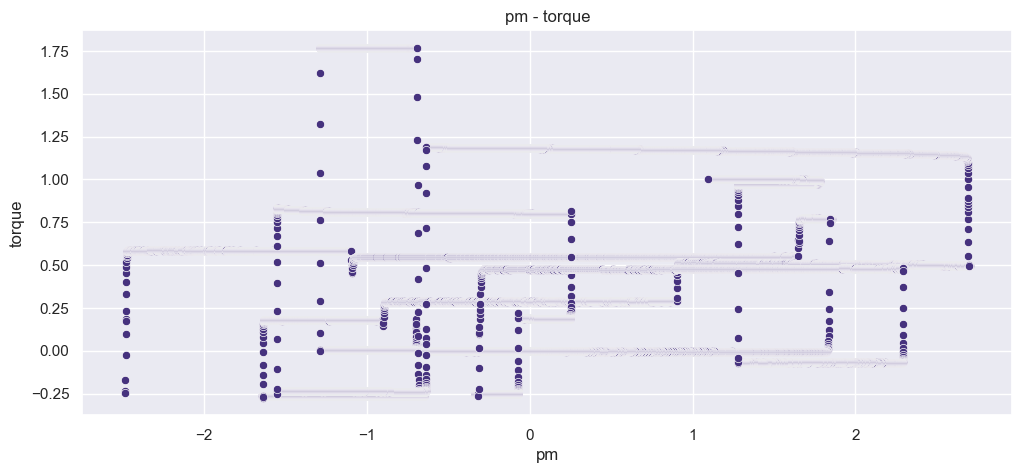

In [33]:
sns.scatterplot(x=random_session['pm'],y=random_session['torque'])
plt.title('pm - torque')
plt.show()

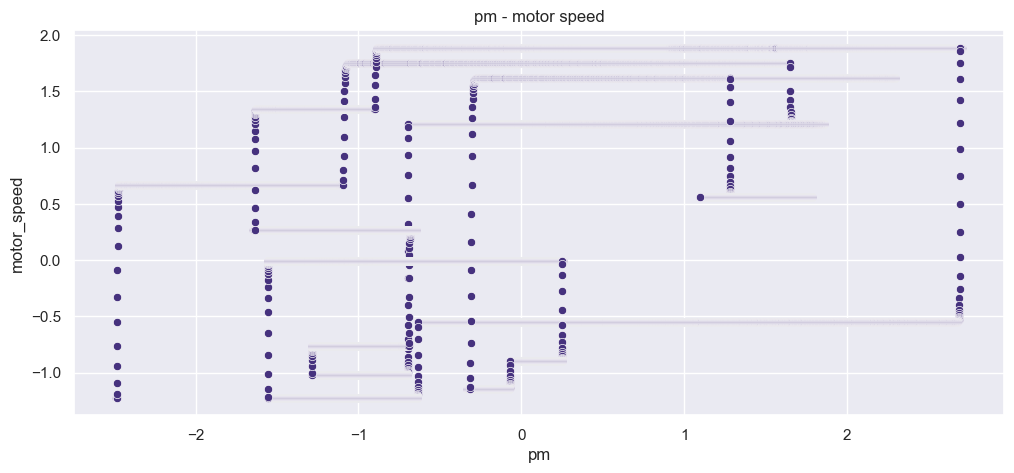

In [34]:
sns.scatterplot(x=random_session['pm'],y=random_session['motor_speed'])
plt.title('pm - motor speed')
plt.show()

## stator_yoke

Stator yoke temperature is measured with a thermal sensor.

Some effects of stator yoke surface temperature on PMSM : <br>
* Electrical Resistance: The stator yoke is typically made of a magnetic material with relatively high electrical conductivity. As the temperature of the stator yoke increases, its electrical resistance also tends to increase. This increased resistance can result in higher copper losses, reducing the motor's overall efficiency.
* Core Losses: The stator yoke is a part of the motor's magnetic core, which can experience core losses due to hysteresis and eddy currents. Elevated temperatures can lead to increased core losses in the stator yoke, resulting in additional heat generation within the motor and reducing its efficiency.


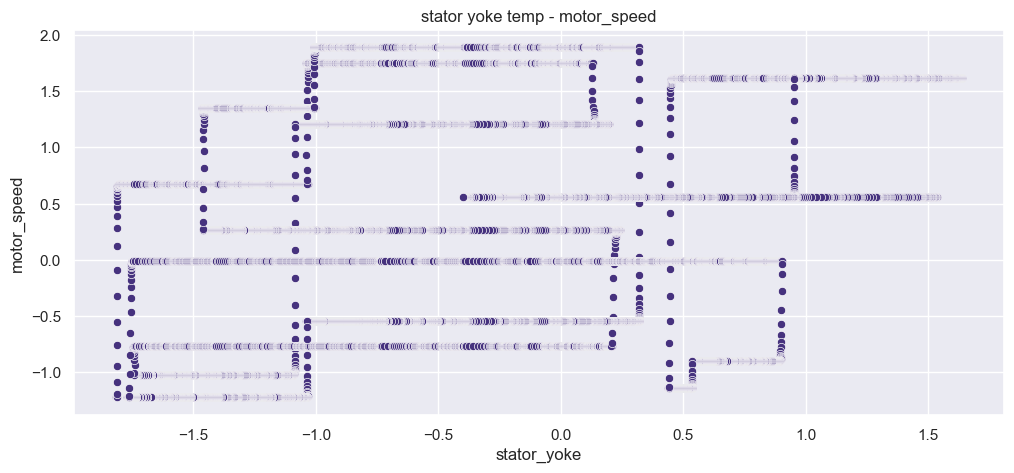

In [35]:
sns.scatterplot(x=random_session['stator_yoke'],y=random_session['motor_speed'])
plt.title('stator yoke temp - motor_speed')
plt.show()

## stator_tooth

Stator tooth temperature is measured with a thermal sensor

Some effects of stator tooth surface temperature on PMSM : <br>
* Electrical Resistance: The stator yoke is typically made of a magnetic material with relatively high electrical conductivity. As the temperature of the stator yoke increases, its electrical resistance also tends to increase. This increased resistance can result in higher copper losses, reducing the motor's overall efficiency.
* Core Losses: The stator yoke is a part of the motor's magnetic core, which can experience core losses due to hysteresis and eddy currents. Elevated temperatures can lead to increased core losses in the stator yoke, resulting in additional heat generation within the motor and reducing its efficiency.

**This has same effect as stator_yoke**

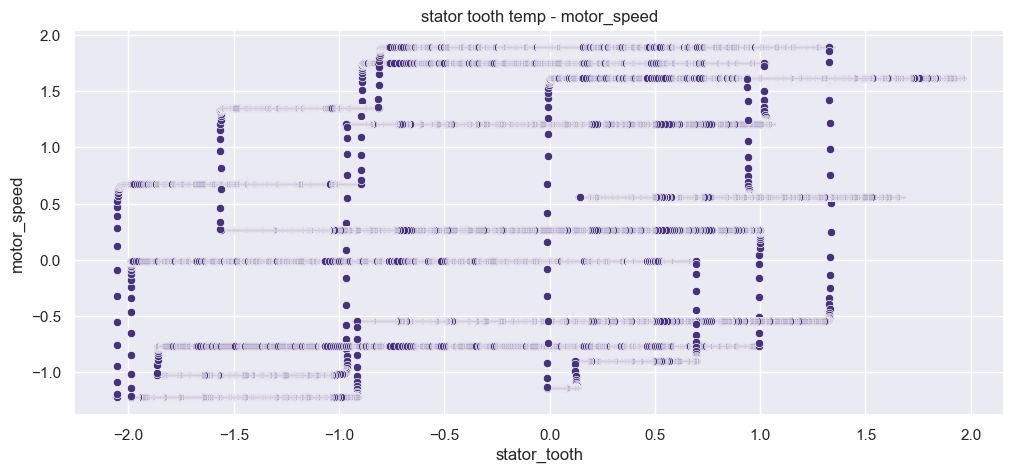

In [36]:
sns.scatterplot(x=random_session['stator_tooth'],y=random_session['motor_speed'])
plt.title('stator tooth temp - motor_speed')
plt.show()

## stator_winding

Stator winding temperature measured with a thermal sensor.

Some effects of stator winding surface temperature on PMSM : <br>
* Electrical Resistance: The stator winding is made of conductive wire that carries the current. As the temperature of the stator winding increases, its electrical resistance also tends to increase. This increased resistance can result in higher copper losses, reduce the motor's overall efficiency, and lead to increased heat generation within the winding itself.

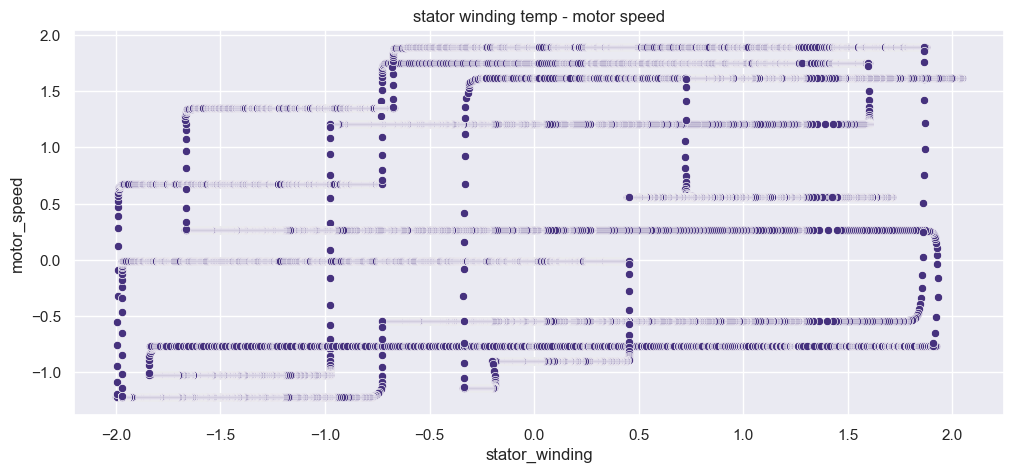

In [37]:
sns.scatterplot(x=random_session['stator_winding'],y=random_session['motor_speed'])
plt.title('stator winding temp - motor speed')
plt.show()

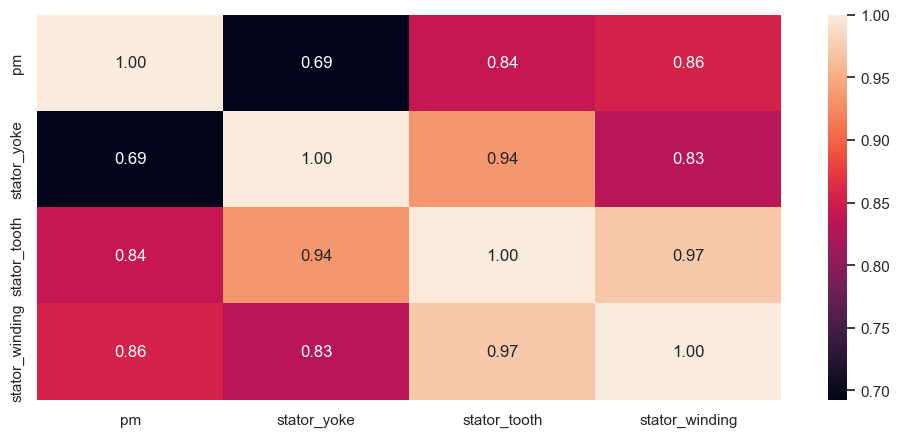

In [38]:
sns.heatmap(random_session[['pm','stator_yoke','stator_tooth','stator_winding']].corr(),annot=True,fmt='.2f')
plt.show()

*Observerd High Correlation between these independent features*

## motor_speed

<Axes: ylabel='motor_speed'>

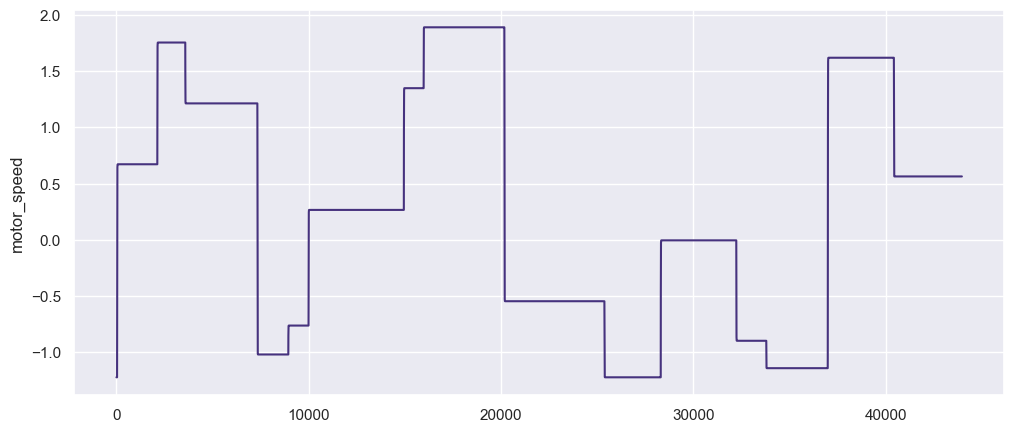

In [39]:
sns.lineplot(x = range(len(random_session)),y = random_session['motor_speed'])

## VIF

In [40]:
X = random_session.drop(['motor_speed','profile_id'],axis=1)
vif_stat = pd.DataFrame()
vif_stat['Feature'] = X.columns
vif_stat['vif'] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]
vif_stat.sort_values('vif')

,Feature,vif
3,u_q,2.930073
0,ambient,4.195571
2,u_d,10.664440
7,pm,14.583008
5,i_d,15.985603
1,coolant,77.602654
6,i_q,414.118970
4,torque,464.419708
10,stator_winding,500.270598
8,stator_yoke,740.073519


# Anova test

* The null hypothesis (H0) : there is no difference among group means. 
* The alternative hypothesis (Ha) : at least one group differs significantly from the overall mean of the dependent variable. 

In [41]:
unique_session = df['profile_id'].unique()

In [42]:
unique_session

array([ 4,  6, 10, 11, 20, 27, 29, 30, 31, 32, 36, 41, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
       64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81,
       72], dtype=int64)

In [43]:
anova_stat = {'Columns':[],'Anova_Pval':[]}
for i in df.columns[:-1]:
    f , p = sta.f_oneway(df[df['profile_id']==4][i],df[df['profile_id']==6][i],
                        df[df['profile_id']==10][i],df[df['profile_id']==11][i],
                        df[df['profile_id']==20][i],df[df['profile_id']==27][i],
                        df[df['profile_id']==29][i],df[df['profile_id']==30][i],
                        df[df['profile_id']==31][i],df[df['profile_id']==32][i],
                        df[df['profile_id']==36][i],df[df['profile_id']==41][i],
                        df[df['profile_id']==42][i],df[df['profile_id']==43][i],
                        df[df['profile_id']==44][i],df[df['profile_id']==45][i],
                        df[df['profile_id']==46][i],df[df['profile_id']==47][i],
                        df[df['profile_id']==48][i],df[df['profile_id']==49][i],
                        df[df['profile_id']==50][i],df[df['profile_id']==51][i],
                        df[df['profile_id']==52][i],df[df['profile_id']==53][i],
                        df[df['profile_id']==54][i],df[df['profile_id']==55][i],
                        df[df['profile_id']==56][i],df[df['profile_id']==57][i],
                        df[df['profile_id']==58][i],df[df['profile_id']==59][i],
                        df[df['profile_id']==60][i],df[df['profile_id']==61][i],
                        df[df['profile_id']==62][i],df[df['profile_id']==63][i],
                        df[df['profile_id']==64][i],df[df['profile_id']==65][i],
                        df[df['profile_id']==66][i],df[df['profile_id']==67][i],
                        df[df['profile_id']==68][i],df[df['profile_id']==69][i],
                        df[df['profile_id']==70][i],df[df['profile_id']==71][i],
                        df[df['profile_id']==73][i],df[df['profile_id']==74][i],
                        df[df['profile_id']==75][i],df[df['profile_id']==76][i],
                        df[df['profile_id']==77][i],df[df['profile_id']==78][i],
                        df[df['profile_id']==79][i],df[df['profile_id']==80][i],
                        df[df['profile_id']==81][i],df[df['profile_id']==72][i])
    anova_stat['Columns'].append(i)
    anova_stat['Anova_Pval'].append(p)
    
    

In [44]:
stat = pd.DataFrame(anova_stat)
stat

,Columns,Anova_Pval
0,ambient,0.0
1,coolant,0.0
2,u_d,0.0
3,u_q,0.0
4,motor_speed,0.0
5,torque,0.0
6,i_d,0.0
7,i_q,0.0
8,pm,0.0
9,stator_yoke,0.0


In [45]:
stat['Significant_difference'] = stat['Anova_Pval'].apply(lambda x : True if x < 0.05 else False)
stat

,Columns,Anova_Pval,Significant_difference
0,ambient,0.0,True
1,coolant,0.0,True
2,u_d,0.0,True
3,u_q,0.0,True
4,motor_speed,0.0,True
5,torque,0.0,True
6,i_d,0.0,True
7,i_q,0.0,True
8,pm,0.0,True
9,stator_yoke,0.0,True


# Preprocessing and Modeling

# PCA

In [46]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [47]:
X = random_session.drop(['motor_speed','profile_id'],axis=1)
Y = random_session['motor_speed']

In [48]:
std = StandardScaler()
scaled = std.fit_transform(X)

In [49]:
pca = PCA()
pca_data = pd.DataFrame(pca.fit_transform(scaled))
pca_data

,0,1,2,3,4,5,6,7,8,9,10
0,-4.504827,0.322177,0.472286,1.523258,-1.402500,0.659248,-0.112315,-0.055691,0.025069,-0.015385,-0.002024
1,-4.512407,0.343720,0.465795,1.520915,-1.420374,0.687499,-0.126681,-0.062211,0.026080,-0.011042,-0.002412
2,-4.511977,0.344156,0.467992,1.523736,-1.421566,0.688896,-0.125871,-0.062874,0.026046,-0.010212,-0.002966
3,-4.514116,0.341939,0.469562,1.521635,-1.420818,0.691230,-0.125466,-0.062807,0.025888,-0.005982,-0.002319
4,-4.514590,0.344517,0.470726,1.522926,-1.425059,0.695099,-0.126849,-0.065540,0.025457,-0.005863,-0.003056
...,...,...,...,...,...,...,...,...,...,...,...
43965,1.944887,1.521784,-0.098123,0.373279,0.653721,-0.893161,0.045544,0.224237,0.070494,0.067647,0.020518
43966,1.945951,1.520489,-0.098609,0.370892,0.653697,-0.891741,0.045882,0.225059,0.068982,0.067414,0.021483
43967,1.946133,1.521195,-0.099256,0.371095,0.653950,-0.891931,0.045729,0.225752,0.069925,0.066628,0.022506
43968,1.945694,1.521577,-0.100194,0.371216,0.654836,-0.891612,0.046249,0.226450,0.069783,0.066412,0.021538


In [50]:
pca.explained_variance_ratio_

array([5.07133132e-01, 2.26586509e-01, 1.07310917e-01, 8.74776775e-02,
       3.47887961e-02, 2.47981954e-02, 7.65596032e-03, 3.71736439e-03,
       3.76575591e-04, 1.20217935e-04, 3.46552100e-05])

In [51]:
np.cumsum(pca.explained_variance_ratio_)

array([0.50713313, 0.73371964, 0.84103056, 0.92850824, 0.96329703,
       0.98809523, 0.99575119, 0.99946855, 0.99984513, 0.99996534,
       1.        ])

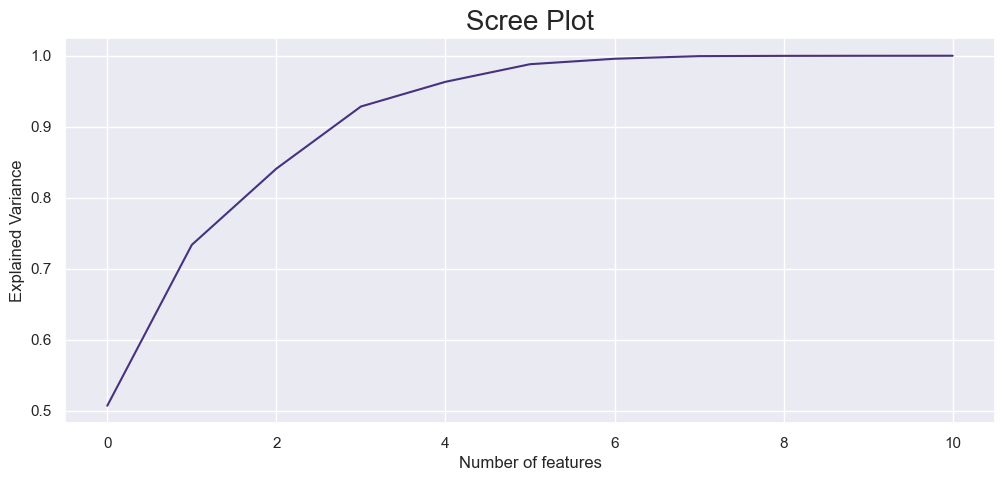

In [52]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of features')
plt.ylabel('Explained Variance')
plt.title('Scree Plot', size = 20)
plt.show()

*Select first 3 pca components.*

In [53]:
pca_f3 = pca_data.iloc[:,:3]
pca_f3

,0,1,2
0,-4.504827,0.322177,0.472286
1,-4.512407,0.343720,0.465795
2,-4.511977,0.344156,0.467992
3,-4.514116,0.341939,0.469562
4,-4.514590,0.344517,0.470726
...,...,...,...
43965,1.944887,1.521784,-0.098123
43966,1.945951,1.520489,-0.098609
43967,1.946133,1.521195,-0.099256
43968,1.945694,1.521577,-0.100194


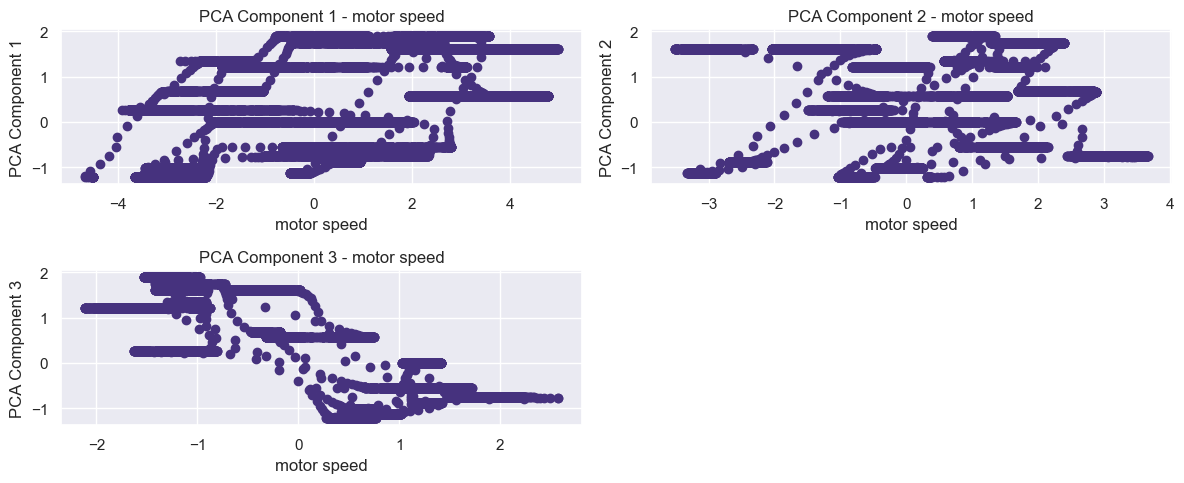

In [54]:
for i in range(3):
    plt.subplot(2,2,i+1)
    plt.scatter(pca_f3.iloc[:,i],Y)
    plt.title(f'PCA Component {i+1} - motor speed')
    plt.xlabel(f'motor speed')
    plt.ylabel(f'PCA Component {i+1}')
    plt.tight_layout()
plt.show()

**We observe stepwise trend, it suggests a potential change in the relationship between the variables at specific points or intervals.** 

# Modeling

In [55]:
model = []
scaled = []
rsqrd_train = []
rsqrd_test = []
mse_train = []
mse_test = []
mae_train = []
mae_test = []

## OLS

OLS, which stands for Ordinary Least Squares, is a widely used method for estimating the parameters of a linear regression model. It aims to find the best-fitting line that minimizes the sum of squared residuals between the predicted values and the actual target values. 

**On PCA Data**

In [56]:
pca_df = pd.DataFrame()
pca_df['f1'] = pca_data[0]
pca_df['f2'] = pca_data[1]
pca_df['f3'] = pca_data[2]
pca_df['motor_speed'] = Y.values
pca_df

,f1,f2,f3,motor_speed
0,-4.504827,0.322177,0.472286,-1.222431
1,-4.512407,0.343720,0.465795,-1.222432
2,-4.511977,0.344156,0.467992,-1.222431
3,-4.514116,0.341939,0.469562,-1.222431
4,-4.514590,0.344517,0.470726,-1.222431
...,...,...,...,...
43965,1.944887,1.521784,-0.098123,0.563170
43966,1.945951,1.520489,-0.098609,0.563170
43967,1.946133,1.521195,-0.099256,0.563170
43968,1.945694,1.521577,-0.100194,0.563172


In [57]:
train = pca_df.iloc[:len(pca_df)-15000]
test = pca_df.iloc[len(pca_df)-15000:]
train.shape , test.shape

((28970, 4), (15000, 4))

In [58]:
pca_model = sfa.ols('motor_speed~f1+f2+f3',data=train).fit()

In [59]:
pca_model.rsquared

0.9291861128147897

In [60]:
pred = pca_model.predict(test.drop('motor_speed',axis=1))
pred

28970   -1.231316
28971   -1.235140
28972   -1.236627
28973   -1.231252
28974   -1.225631
           ...   
43965    0.817430
43966    0.817533
43967    0.818352
43968    0.819251
43969    0.819506
Length: 15000, dtype: float64

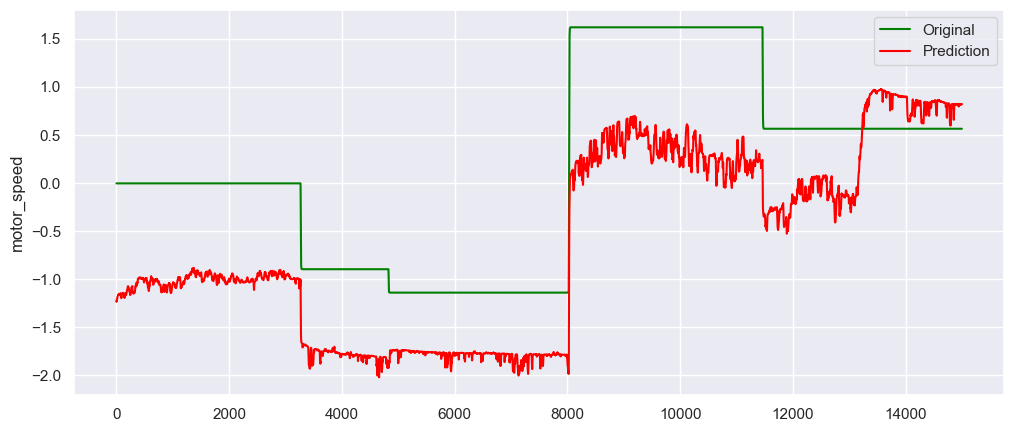

In [61]:
sns.lineplot(x=range(len(test)),y=test['motor_speed'],color='green',label='Original')
sns.lineplot(x=range(len(test)),y=pred,color='red',label='Prediction')
plt.legend()
plt.show()

In [62]:
print(f"Model Score:\
\nR_Squared OLS (train) : {r2_score(train['motor_speed'],pca_model.predict(train.drop('motor_speed',axis=1)))}\
\nR_Squared OLS (test) : {r2_score(test['motor_speed'],pred)} \
\nMSE OLS(train) : {mean_squared_error(train['motor_speed'],pca_model.predict(train.drop('motor_speed',axis=1)))}\
\nMSE OLS(test) : {mean_squared_error(test['motor_speed'],pred)}\
\nMAE OLS(train) : {mean_absolute_error(train['motor_speed'],pca_model.predict(train.drop('motor_speed',axis=1)))}\
\nMAE OLS(test) : {mean_absolute_error(test['motor_speed'],pred)}")

Model Score:
R_Squared OLS (train) : 0.9291861128147897
R_Squared OLS (test) : 0.1401537620758746 
MSE OLS(train) : 0.0800698072945075
MSE OLS(test) : 0.8663460034450708
MAE OLS(train) : 0.21821211695189227
MAE OLS(test) : 0.8670211092312354


**observed Overfitting**

In [63]:
model.append('OLS PCA SINGLE SESSION')
scaled.append(True)
rsqrd_train.append(r2_score(train['motor_speed'],pca_model.predict(train.drop('motor_speed',axis=1))))
rsqrd_test.append(r2_score(test['motor_speed'],pred))
mse_train.append(mean_squared_error(train['motor_speed'],pca_model.predict(train.drop('motor_speed',axis=1))))
mse_test.append(mean_squared_error(test['motor_speed'],pred))
mae_train.append(mean_absolute_error(train['motor_speed'],pca_model.predict(train.drop('motor_speed',axis=1))))
mae_test.append(mean_absolute_error(test['motor_speed'],pred))

## Modeling on Full Data

**OLS on Full Raw Data**

In [64]:
df.shape

(998070, 13)

In [65]:
train = df[df['profile_id']!=10]

In [66]:
ols_model = sfa.ols('motor_speed~ambient+coolant+u_d+u_q+torque+i_d+i_q+pm+stator_yoke+stator_tooth+stator_winding',data=train).fit()

In [67]:
ols_model.rsquared

0.9378375745757138

In [68]:
ols_model.params

Intercept         0.009853
ambient          -0.049139
coolant           0.327763
u_d              -0.259365
u_q               0.541892
torque           -0.176097
i_d              -0.645781
i_q              -0.191675
pm                0.095965
stator_yoke      -1.323745
stator_tooth      1.912936
stator_winding   -0.984077
dtype: float64

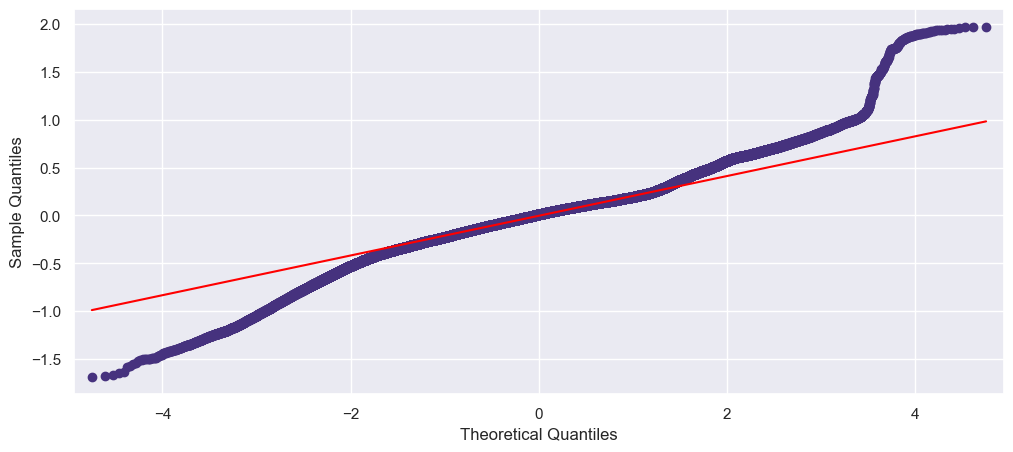

In [69]:
sa.qqplot(ols_model.resid,line='q');

**Not Ideal Performance**

### Cooks distance

In [70]:
inf = ols_model.get_influence()
c,p=inf.cooks_distance

<StemContainer object of 3 artists>

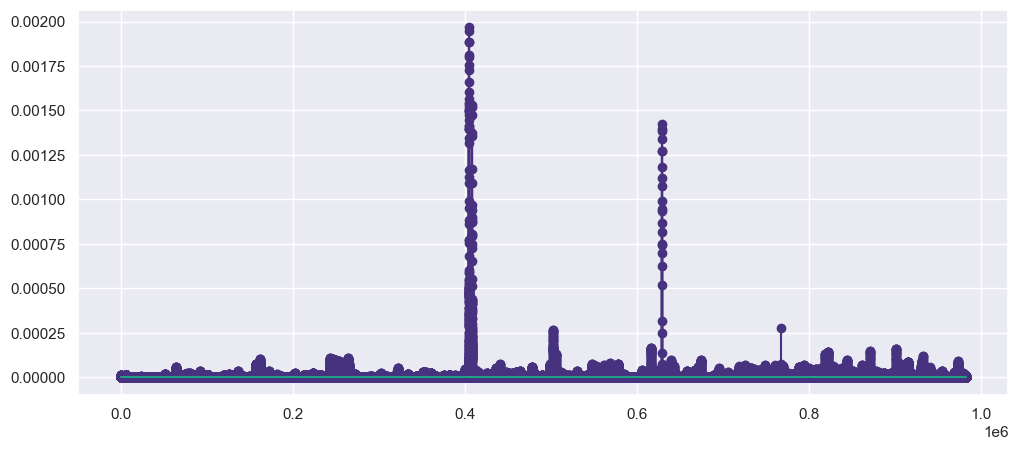

In [71]:
plt.stem(c)

In [72]:
#Calculate cutoff
k = len(train.columns)
n = len(train)

levarge_cutoff = 3*(k+1)/n
levarge_cutoff

4.2734390500755485e-05

In [73]:
#drop values which exceed the threshold value
h_val = ols_model.get_influence().hat_matrix_diag # get h leverage value
train[h_val>levarge_cutoff] # gives position where h_val crosses threshold

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
51300,0.695553,-0.027250,-1.170349,0.700379,1.483027,0.340199,-0.987787,0.312550,1.919333,1.327860,1.425259,1.261606,6
51301,0.693584,-0.066144,-1.169892,0.700574,1.483027,0.340706,-0.987837,0.312235,1.918312,1.327987,1.424532,1.261606,6
51302,0.694022,-0.097926,-1.170371,0.700321,1.483029,0.341182,-0.989392,0.312702,1.918190,1.328380,1.424209,1.261606,6
51303,0.698763,-0.122149,-1.169601,0.699563,1.483031,0.341962,-0.991393,0.312652,1.917903,1.328616,1.425240,1.261606,6
51304,0.695884,-0.140836,-1.168549,0.703775,1.483023,0.342405,-0.992426,0.312486,1.917599,1.328847,1.425293,1.261606,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
989729,-2.528476,-1.078828,0.781064,1.368994,1.937356,-0.512008,-0.865224,-0.484981,0.375969,-0.734718,-0.761952,-0.719982,72
997988,-0.046497,0.488698,0.330806,-1.246857,-1.222435,-0.255640,1.029144,-0.245703,0.449736,1.292880,0.954659,0.598877,72
997989,-0.034792,0.483181,0.330408,-1.245156,-1.222430,-0.255640,1.029150,-0.245726,0.449911,1.292892,0.953731,0.596688,72
997990,-0.040338,0.488894,0.330477,-1.247391,-1.222431,-0.255640,1.029201,-0.245705,0.449423,1.292948,0.953689,0.595937,72


In [74]:
train.drop(index=train[h_val>levarge_cutoff].index,inplace=True)

C:\Users\shiva\AppData\Local\Temp\ipykernel_1432\951422542.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(index=train[h_val>levarge_cutoff].index,inplace=True)


In [75]:
train.reset_index(inplace=True)

In [76]:
imp_model = sfa.ols('motor_speed~ambient+coolant+u_d+u_q+torque+i_d+i_q+pm+stator_yoke+stator_tooth+stator_winding',data=train).fit()

In [77]:
imp_model.rsquared

0.9395907222847714

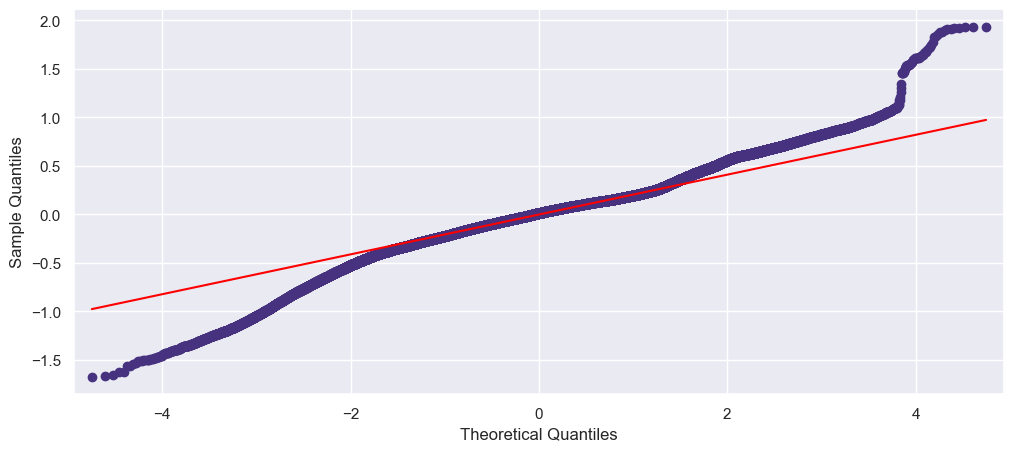

In [78]:
sa.qqplot(imp_model.resid,line='q');

In [79]:
test = df[df['profile_id']==10]
test

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
73810,-2.528476,-1.062121,0.332536,-1.276879,-1.222431,-0.243307,1.029137,-0.245723,-2.523518,-1.821232,-2.059317,-2.004226,10
73811,-2.528476,-1.063101,0.333189,-1.279757,-1.222427,-0.243990,1.029156,-0.245716,-2.523157,-1.820785,-2.059384,-2.003720,10
73812,-2.528476,-1.063239,0.331893,-1.275739,-1.222429,-0.243168,1.029164,-0.245706,-2.523007,-1.820142,-2.059412,-2.003322,10
73813,-2.528476,-1.063951,0.332184,-1.275931,-1.222434,-0.243421,1.029162,-0.245707,-2.522884,-1.820761,-2.059477,-2.003290,10
73814,-2.528476,-1.064603,0.333302,-1.278150,-1.222428,-0.243996,1.029153,-0.245726,-2.522788,-1.821586,-2.059511,-2.003568,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89060,-1.003415,-1.077639,0.514130,-0.146537,-0.646170,-0.574266,0.994299,-0.617411,-2.053915,-1.672523,-1.830432,-1.832824,10
89061,-1.003514,-1.076510,0.514207,-0.146548,-0.646169,-0.574300,0.994302,-0.617412,-2.054137,-1.673133,-1.830422,-1.831649,10
89062,-1.003584,-1.074323,0.514173,-0.146501,-0.646168,-0.574198,0.994303,-0.617410,-2.054512,-1.676905,-1.830414,-1.832202,10
89063,-1.002618,-1.072655,0.514255,-0.146501,-0.646164,-0.574235,0.994299,-0.617411,-2.055000,-1.678567,-1.830408,-1.831754,10


In [80]:
pred = imp_model.predict(test.drop(['profile_id','motor_speed'],axis=1))
pred

73810   -1.362592
73811   -1.365826
73812   -1.364913
73813   -1.364559
73814   -1.364758
           ...   
89060   -0.611355
89061   -0.611172
89062   -0.604247
89063   -0.601682
89064   -0.604626
Length: 15255, dtype: float64

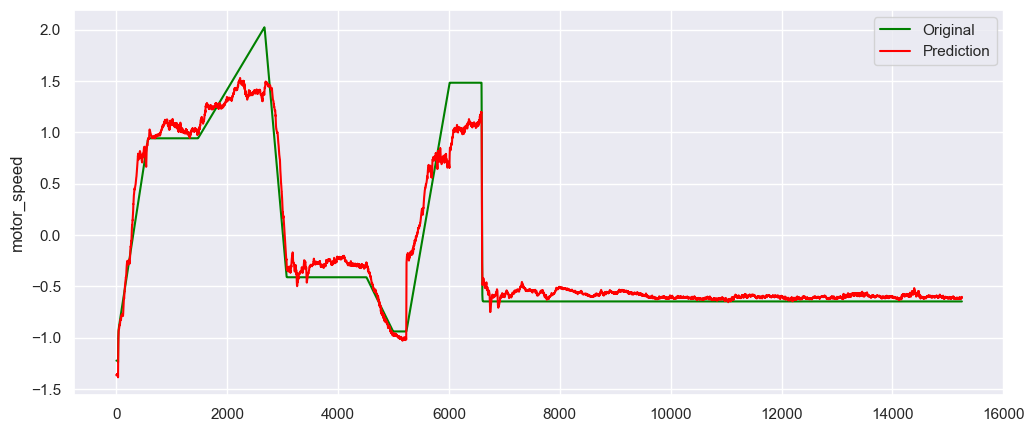

In [81]:
sns.lineplot(x=range(len(test)),y=test['motor_speed'],color='green',label='Original')
sns.lineplot(x=range(len(test)),y=pred,color='red',label='Prediction')
plt.legend()
plt.show()

In [82]:
print(f"Model Score:\
\nR_Squared  (train) : {r2_score(train['motor_speed'],imp_model.predict(train.drop(['profile_id','motor_speed'],axis=1)))}\
\nR_Squared  (test) : {r2_score(test['motor_speed'],pred)}\
\nMSE (train) : {mean_squared_error(train['motor_speed'],imp_model.predict(train.drop(['profile_id','motor_speed'],axis=1)))}\
\nMSE (test) : {mean_squared_error(test['motor_speed'],pred)}\
\nMAE (train) : {mean_absolute_error(train['motor_speed'],imp_model.predict(train.drop(['profile_id','motor_speed'],axis=1)))}\
\nMAE (test) : {mean_absolute_error(test['motor_speed'],pred)}")

Model Score:
R_Squared  (train) : 0.9395907222847714
R_Squared  (test) : 0.9521395011634602
MSE (train) : 0.06086332716804408
MSE (test) : 0.0305611188315291
MAE (train) : 0.18379700064318957
MAE (test) : 0.11592749500624112


In [83]:
model.append('OLS FULL DATA')
scaled.append(False)
rsqrd_train.append(r2_score(train['motor_speed'],imp_model.predict(train.drop(['profile_id','motor_speed'],axis=1))))
rsqrd_test.append(r2_score(test['motor_speed'],pred))
mse_train.append(mean_squared_error(train['motor_speed'],imp_model.predict(train.drop(['profile_id','motor_speed'],axis=1))))
mse_test.append(mean_squared_error(test['motor_speed'],pred))
mae_train.append(mean_absolute_error(train['motor_speed'],imp_model.predict(train.drop(['profile_id','motor_speed'],axis=1))))
mae_test.append(mean_absolute_error(test['motor_speed'],pred))

### Modeling & PreProcessing

### Feature Selection

In [84]:
from sklearn.tree import DecisionTreeRegressor

The Decision Tree Regressor is a machine learning algorithm that is used for regression tasks. It builds a binary tree structure by recursively partitioning the input feature space based on the values of the input features. Each internal node of the tree represents a decision based on a specific feature, while each leaf node represents a predicted value. 

In [85]:
dtreg = DecisionTreeRegressor().fit(df.drop(['profile_id','motor_speed'],axis=1),df['motor_speed'])

In [86]:
dtreg.feature_importances_

array([4.94061026e-05, 5.26942435e-04, 3.11584046e-02, 1.96071498e-01,
       2.91570862e-04, 5.26616561e-01, 2.44555993e-01, 3.87482897e-04,
       1.00186261e-04, 1.25642502e-04, 1.16312770e-04])

In [87]:
feature_imp = pd.DataFrame({'Feature':df.drop(['profile_id','motor_speed'],axis=1).columns,
                            'feature_imp':dtreg.feature_importances_})
feature_imp.sort_values('feature_imp',ascending=False)

,Feature,feature_imp
5,i_d,0.526617
6,i_q,0.244556
3,u_q,0.196071
2,u_d,0.031158
1,coolant,0.000527
7,pm,0.000387
4,torque,0.000292
9,stator_tooth,0.000126
10,stator_winding,0.000116
8,stator_yoke,0.000100


*Lets Use first 7 columns*

In [88]:
important_features = feature_imp.sort_values('feature_imp',ascending=False)['Feature'].iloc[:7].values
important_features

array(['i_d', 'i_q', 'u_q', 'u_d', 'coolant', 'pm', 'torque'],
      dtype=object)

### PCA

*Using pca to handel multicolinearity*

In [89]:
X = df.drop(['profile_id','motor_speed'],axis=1)
Y = df['motor_speed']

In [90]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

In [91]:
xtrain,xtest,ytrain,ytest = train_test_split(X_pca,Y,random_state=42,test_size=0.2,shuffle=False)

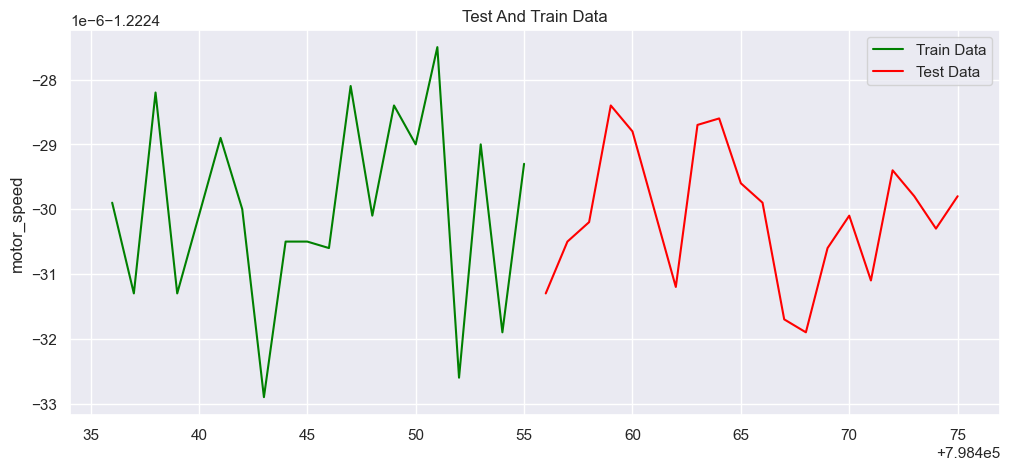

In [92]:
sns.lineplot(x=range(len(xtrain)-20,len(xtrain)),y=ytrain[len(xtrain)-20:],label='Train Data',color='green')
sns.lineplot(x=range(len(xtrain),len(xtrain)+20),y=ytest[:20],label='Test Data',color='red')
plt.legend()
plt.title("Test And Train Data")
plt.show()

## SGD Regressor

SGD Regressor, short for Stochastic Gradient Descent Regressor, is a machine learning algorithm that performs linear regression using stochastic gradient descent optimization. It is particularly useful when dealing with large datasets 

**Stochastic Gradient Descent (SGD)** optimization is an iterative optimization algorithm but instead of using the entire dataset to compute the gradient at each step, it uses a randomly selected subset of data points.

*SGD Works ideally for huge size dataset*

lets also use pca to handel multicolinearity

In [93]:
from sklearn.linear_model import SGDRegressor

**Scaling the data before applying pca gives better performance**<br>
* It is recommended to scale data when using PCA data with SGDRegressor.

In [94]:
std = StandardScaler()

In [95]:
X_scaled = std.fit_transform(X)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

In [96]:
xtrain,xtest,ytrain,ytest = train_test_split(X_pca,Y,random_state=42,test_size=0.2,shuffle=False)

In [97]:
sgreg = SGDRegressor(penalty='l1',loss="squared_error",random_state=42) # l1 for lasso operation
sgreg.fit(xtrain,ytrain)

SGDRegressor(penalty='l1', random_state=42)

In [98]:
sgd_pred = sgreg.predict(xtest)

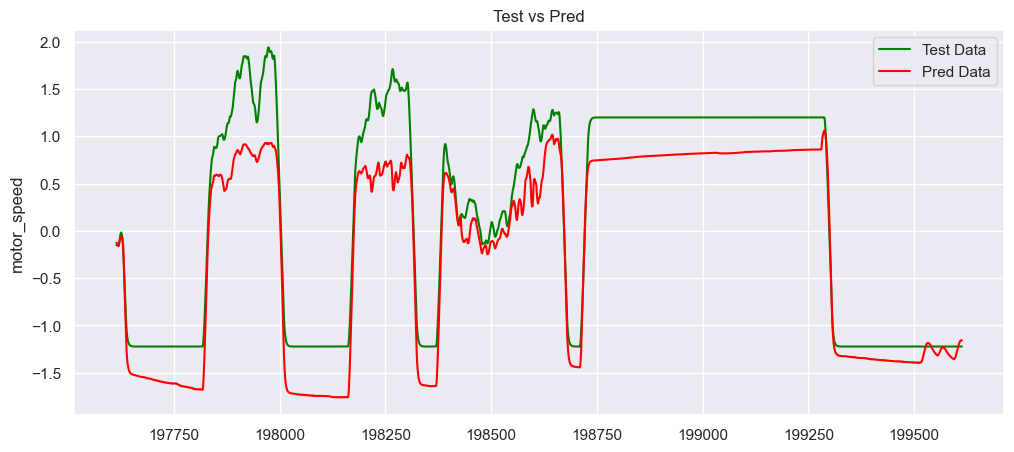

In [99]:
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=ytest[len(xtest)-2000:],label='Test Data',color='green')
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=sgd_pred[len(xtest)-2000:],label='Pred Data',color='red')
plt.legend()
plt.title('Test vs Pred')
plt.show()

In [100]:
print(f"Model Score:\
\nR_Squared SGD (train) : {r2_score(ytrain,sgreg.predict(xtrain))}\
\nR_Squared SGD (test) : {r2_score(ytest,sgd_pred)} \
\nMSE (train) : {mean_squared_error(ytrain,sgreg.predict(xtrain))}\
\nMSE (test) : {mean_squared_error(ytest,sgd_pred)}\
\nMAE (train) : {mean_absolute_error(ytrain,sgreg.predict(xtrain))}\
\nMAE (test) : {mean_absolute_error(ytest,sgd_pred)}")

Model Score:
R_Squared SGD (train) : 0.859798046274915
R_Squared SGD (test) : 0.8786133515361538 
MSE (train) : 0.13610990764471972
MSE (test) : 0.1294962726308862
MAE (train) : 0.2899710960853578
MAE (test) : 0.2860782077126686


In [101]:
model.append('SGD PCA FULL DATA')
scaled.append(True)
rsqrd_train.append(r2_score(ytrain,sgreg.predict(xtrain)))
rsqrd_test.append(r2_score(ytest,sgd_pred))
mse_train.append(mean_squared_error(ytrain,sgreg.predict(xtrain)))
mse_test.append(mean_squared_error(ytest,sgd_pred))
mae_train.append(mean_absolute_error(ytrain,sgreg.predict(xtrain)))
mae_test.append(mean_absolute_error(ytest,sgd_pred))

**Also try with raw data**

In [102]:
X_fe_df = df[important_features]
X_fe_df

,i_d,i_q,u_q,u_d,coolant,pm,torque
0,1.029572,-0.245860,-1.297858,0.327935,-1.118446,-2.522071,-0.250182
1,1.029509,-0.245832,-1.297686,0.329665,-1.117021,-2.522418,-0.249133
2,1.029448,-0.245818,-1.301822,0.332771,-1.116681,-2.522673,-0.249431
3,1.032845,-0.246955,-1.301852,0.333700,-1.116764,-2.521639,-0.248636
4,1.031807,-0.246610,-1.303118,0.335206,-1.116775,-2.521900,-0.248701
...,...,...,...,...,...,...,...
998065,1.029142,-0.245723,-1.246114,0.331475,0.341638,0.429853,-0.255640
998066,1.029148,-0.245736,-1.250655,0.331701,0.320022,0.429751,-0.255640
998067,1.029191,-0.245701,-1.246852,0.330946,0.307415,0.429439,-0.255640
998068,1.029147,-0.245727,-1.249505,0.330987,0.302082,0.429558,-0.255640


In [103]:
Y_fe_df = df['motor_speed']
Y_fe_df

0        -1.222428
1        -1.222429
2        -1.222428
3        -1.222430
4        -1.222429
            ...   
998065   -1.222428
998066   -1.222437
998067   -1.222430
998068   -1.222432
998069   -1.222431
Name: motor_speed, Length: 998070, dtype: float64

In [104]:
xtrain,xtest,ytrain,ytest = train_test_split(X_fe_df,Y_fe_df,random_state=42,test_size=0.2,shuffle=False)

In [105]:
sgreg = SGDRegressor(penalty='l1',loss="squared_error",random_state=42) # l1 fro lasso operation
sgreg.fit(xtrain,ytrain)

SGDRegressor(penalty='l1', random_state=42)

In [106]:
sgd_pred = sgreg.predict(xtest)

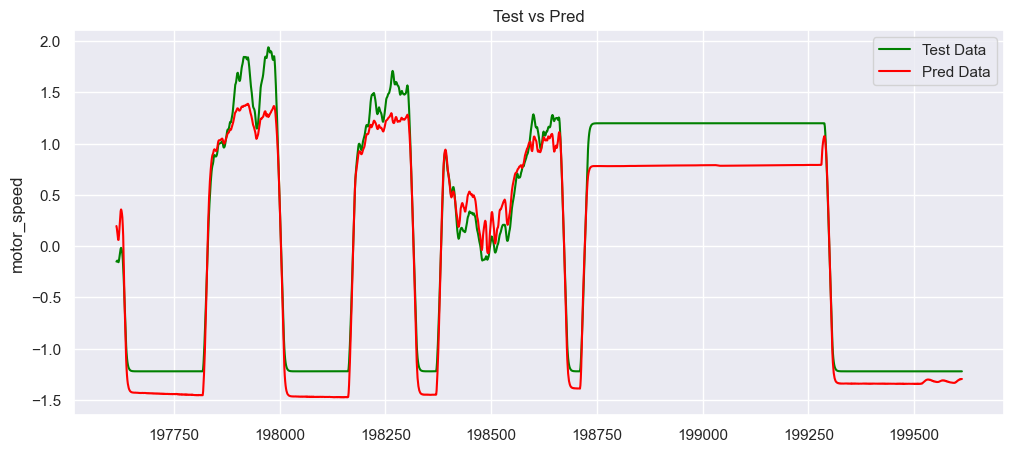

In [107]:
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=ytest[len(xtest)-2000:],label='Test Data',color='green')
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=sgd_pred[len(xtest)-2000:],label='Pred Data',color='red')
plt.legend()
plt.title('Test vs Pred')
plt.show()

In [108]:
print(f"Model Score:\
\nR_Squared SGD (train) : {r2_score(ytrain,sgreg.predict(xtrain))}\
\nR_Squared SGD (test) : {r2_score(ytest,sgd_pred)} \
\nMSE (train) : {mean_squared_error(ytrain,sgreg.predict(xtrain))}\
\nMSE (test) : {mean_squared_error(ytest,sgd_pred)}\
\nMAE (train) : {mean_absolute_error(ytrain,sgreg.predict(xtrain))}\
\nMAE (test) : {mean_absolute_error(ytest,sgd_pred)}")

Model Score:
R_Squared SGD (train) : 0.9231724041497584
R_Squared SGD (test) : 0.9292201671099513 
MSE (train) : 0.07458524434150779
MSE (test) : 0.07550850651773477
MAE (train) : 0.20283873996735924
MAE (test) : 0.20207694550129032


In [109]:
model.append('SGD FULL DATA')
scaled.append(False)
rsqrd_train.append(r2_score(ytrain,sgreg.predict(xtrain)))
rsqrd_test.append(r2_score(ytest,sgd_pred))
mse_train.append(mean_squared_error(ytrain,sgreg.predict(xtrain)))
mse_test.append(mean_squared_error(ytest,sgd_pred))
mae_train.append(mean_absolute_error(ytrain,sgreg.predict(xtrain)))
mae_test.append(mean_absolute_error(ytest,sgd_pred))

## Ridge

Ridge regression is a linear regression algorithm that is used to tackle the problem of multicollinearity and overfitting in regression models. It introduces a regularization term to the traditional linear regression objective function, which helps to control the complexity of the model and reduce the impact of highly correlated features.

The Ridge regression algorithm uses the L2 norm, also known as the Euclidean norm or the squared Euclidean norm.

In [110]:
from sklearn.linear_model import Ridge

In [111]:
X_fe_df = df[important_features]
Y_fe_df = df['motor_speed']
std = StandardScaler()
X_scaled = std.fit_transform(X_fe_df)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

In [112]:
xtrain,xtest,ytrain,ytest = train_test_split(X_pca,Y_fe_df,random_state=42,test_size=0.2,shuffle=False)

In [113]:
rd = Ridge().fit(xtrain,ytrain)

In [114]:
pred = rd.predict(xtest)

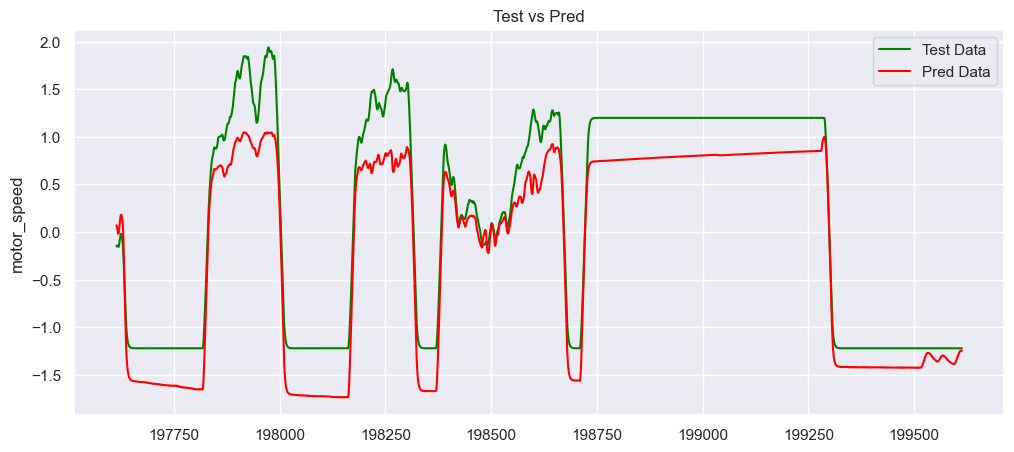

In [115]:
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=ytest[len(xtest)-2000:],label='Test Data',color='green')
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=pred[len(xtest)-2000:],label='Pred Data',color='red')
plt.legend()
plt.title('Test vs Pred')
plt.show()

In [116]:
print(f"Model Score:\
\nR_Squared Ridge (train) : {r2_score(ytrain,rd.predict(xtrain))}\
\nR_Squared Ridge (test) : {r2_score(ytest,pred)} \
\nMSE (train) : {mean_squared_error(ytrain,rd.predict(xtrain))}\
\nMSE (test) : {mean_squared_error(ytest,pred)}\
\nMAE (train) : {mean_absolute_error(ytrain,rd.predict(xtrain))}\
\nMAE (test) : {mean_absolute_error(ytest,pred)}")

Model Score:
R_Squared Ridge (train) : 0.8896675719008754
R_Squared Ridge (test) : 0.9019290010426435 
MSE (train) : 0.10711217782482733
MSE (test) : 0.10462294641858985
MAE (train) : 0.2585790325631725
MAE (test) : 0.2523554520281698


In [117]:
model.append('RIDGE PCA FULL DATA')
scaled.append(True)
rsqrd_train.append(r2_score(ytrain,rd.predict(xtrain)))
rsqrd_test.append(r2_score(ytest,pred))
mse_train.append(mean_squared_error(ytrain,rd.predict(xtrain)))
mse_test.append(mean_squared_error(ytest,pred))
mae_train.append(mean_absolute_error(ytrain,rd.predict(xtrain)))
mae_test.append(mean_absolute_error(ytest,pred))

## Random Forest 

Random Forest Regressor is a machine learning algorithm that is used for regression tasks. It is an ensemble learning method that combines multiple decision trees to make predictions. The key idea behind the Random Forest Regressor is to reduce overfitting by averaging the predictions of multiple individual decision trees.

In [118]:
from sklearn.ensemble import RandomForestRegressor

In [119]:
X_fe_df = df[important_features]
Y_fe_df = df['motor_speed']
xtrain,xtest,ytrain,ytest = train_test_split(X_fe_df,Y_fe_df,random_state=42,test_size=0.2,shuffle=False)

In [120]:
# rf = RandomForestRegressor().fit(xtrain,ytrain)

In [121]:
rf = pkl.load(open('./backups/random_forest.pkl','rb'))

In [122]:
rf_pred = rf.predict(xtest)

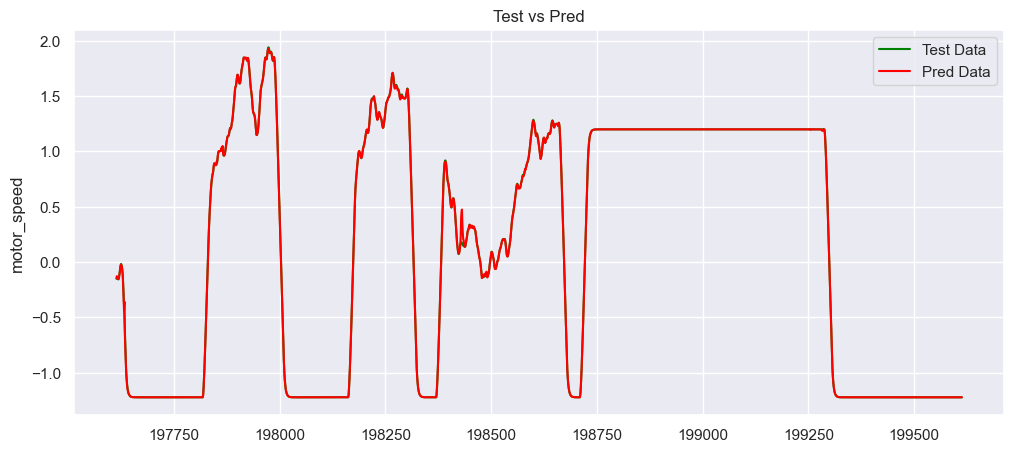

In [123]:
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=ytest[len(xtest)-2000:],label='Test Data',color='green')
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=rf_pred[len(xtest)-2000:],label='Pred Data',color='red')
plt.legend()
plt.title('Test vs Pred')
plt.show()

In [124]:
print(f"Model Score:\
\nR_Squared RF (train) : {r2_score(ytrain,rf.predict(xtrain))}\
\nR_Squared RF (test) : {r2_score(ytest,rf_pred)} \
\nMSE (train) : {mean_squared_error(ytrain,rf.predict(xtrain))}\
\nMSE (test) : {mean_squared_error(ytest,rf_pred)}\
\nMAE (train) : {mean_absolute_error(ytrain,rf.predict(xtrain))}\
\nMAE (test) : {mean_absolute_error(ytest,rf_pred)}")

Model Score:
R_Squared RF (train) : 0.9999779383128914
R_Squared RF (test) : 0.9999691909251857 
MSE (train) : 2.1417777106909673e-05
MSE (test) : 3.286737381871339e-05
MAE (train) : 0.001261447745500735
MAE (test) : 0.002284172671986229


In [125]:
model.append('RANDOM FOREST FULL DATA')
scaled.append(False)
rsqrd_train.append(r2_score(ytrain,rf.predict(xtrain)))
rsqrd_test.append(r2_score(ytest,rf_pred))
mse_train.append(mean_squared_error(ytrain,rf.predict(xtrain)))
mse_test.append(mean_squared_error(ytest,rf_pred))
mae_train.append(mean_absolute_error(ytrain,rf.predict(xtrain)))
mae_test.append(mean_absolute_error(ytest,rf_pred))

# More Models

# Catboost 

CatBoost Regressor uses weak learners, specifically decision trees, as its base models. In gradient boosting algorithms like CatBoost, the weak learners are typically shallow decision trees with limited depth.

In [126]:
from catboost import CatBoostRegressor

In [127]:
cbr = CatBoostRegressor().fit(xtrain,ytrain)

Learning rate set to 0.117689
0:	learn: 0.8814046	total: 216ms	remaining: 3m 35s
1:	learn: 0.7893127	total: 262ms	remaining: 2m 10s
2:	learn: 0.7085953	total: 304ms	remaining: 1m 41s
3:	learn: 0.6351391	total: 347ms	remaining: 1m 26s
4:	learn: 0.5708479	total: 390ms	remaining: 1m 17s
5:	learn: 0.5138304	total: 433ms	remaining: 1m 11s
6:	learn: 0.4624263	total: 478ms	remaining: 1m 7s
7:	learn: 0.4176030	total: 526ms	remaining: 1m 5s
8:	learn: 0.3770780	total: 574ms	remaining: 1m 3s
9:	learn: 0.3420302	total: 619ms	remaining: 1m 1s
10:	learn: 0.3105607	total: 662ms	remaining: 59.6s
11:	learn: 0.2826894	total: 706ms	remaining: 58.1s
12:	learn: 0.2584712	total: 748ms	remaining: 56.8s
13:	learn: 0.2372913	total: 789ms	remaining: 55.6s
14:	learn: 0.2172033	total: 831ms	remaining: 54.5s
15:	learn: 0.2001078	total: 874ms	remaining: 53.7s
16:	learn: 0.1849386	total: 924ms	remaining: 53.4s
17:	learn: 0.1712174	total: 965ms	remaining: 52.7s
18:	learn: 0.1596702	total: 1.01s	remaining: 52.4s
19:	l

In [128]:
cbr_pred = cbr.predict(xtest)

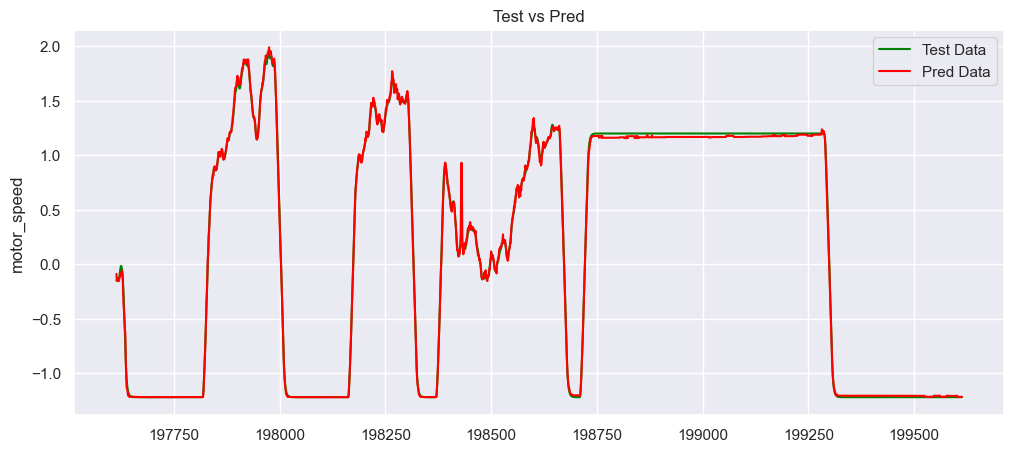

In [129]:
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=ytest[len(xtest)-2000:],label='Test Data',color='green')
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=cbr_pred[len(xtest)-2000:],label='Pred Data',color='red')
plt.legend()
plt.title('Test vs Pred')
plt.show()

In [130]:
print(f"Model Score:\
\nR_Squared CB (train) : {r2_score(ytrain,cbr.predict(xtrain))}\
\nR_Squared CB (test) : {r2_score(ytest,cbr_pred)} \
\nMSE (train) : {mean_squared_error(ytrain,cbr.predict(xtrain))}\
\nMSE (test) : {mean_squared_error(ytest,cbr_pred)}\
\nMAE (train) : {mean_absolute_error(ytrain,cbr.predict(xtrain))}\
\nMAE (test) : {mean_absolute_error(ytest,cbr_pred)}")

Model Score:
R_Squared CB (train) : 0.999718364884771
R_Squared CB (test) : 0.9995658111548182 
MSE (train) : 0.00027341508805582576
MSE (test) : 0.00046319622281763617
MAE (train) : 0.009056558302761584
MAE (test) : 0.012015270817537851


In [131]:
model.append('CATBOOST FULL DATA')
scaled.append(False)
rsqrd_train.append(r2_score(ytrain,cbr.predict(xtrain)))
rsqrd_test.append(r2_score(ytest,cbr_pred))
mse_train.append(mean_squared_error(ytrain,cbr.predict(xtrain)))
mse_test.append(mean_squared_error(ytest,cbr_pred))
mae_train.append(mean_absolute_error(ytrain,cbr.predict(xtrain)))
mae_test.append(mean_absolute_error(ytest,cbr_pred))

# Bayesian Ridge

The Bayesian Ridge Regressor is a statistical model used for regression analysis. It is a regularized linear regression model that combines the ridge regression and Bayesian frameworks.

In [132]:
from sklearn.linear_model import BayesianRidge

In [133]:
brdg = BayesianRidge().fit(xtrain,ytrain)

In [134]:
bridge_pred = brdg.predict(xtest)

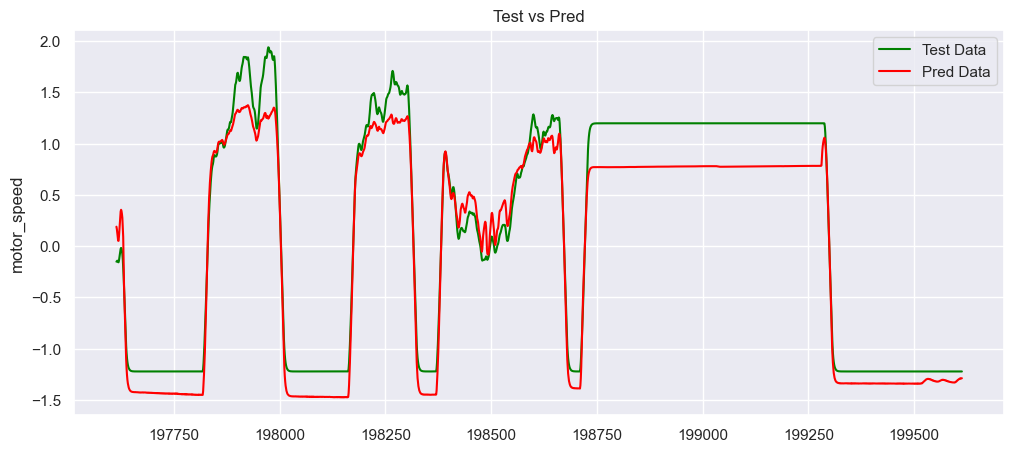

In [135]:
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=ytest[len(xtest)-2000:],label='Test Data',color='green')
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=bridge_pred[len(xtest)-2000:],label='Pred Data',color='red')
plt.legend()
plt.title('Test vs Pred')
plt.show()

In [136]:
print(f"Model Score:\
\nR_Squared BSR (train) : {r2_score(ytrain,brdg.predict(xtrain))}\
\nR_Squared BSR (test) : {r2_score(ytest,bridge_pred)} \
\nMSE (train) : {mean_squared_error(ytrain,brdg.predict(xtrain))}\
\nMSE (test) : {mean_squared_error(ytest,bridge_pred)}\
\nMAE (train) : {mean_absolute_error(ytrain,brdg.predict(xtrain))}\
\nMAE (test) : {mean_absolute_error(ytest,bridge_pred)}")

Model Score:
R_Squared BSR (train) : 0.9232454800816312
R_Squared BSR (test) : 0.9283919243161024 
MSE (train) : 0.07451430126208561
MSE (test) : 0.07639208272643755
MAE (train) : 0.20081472383662172
MAE (test) : 0.2002971027962069


In [137]:
model.append('BAYESIAN RIDGE FULL DATA')
scaled.append(False)
rsqrd_train.append(r2_score(ytrain,brdg.predict(xtrain)))
rsqrd_test.append(r2_score(ytest,bridge_pred))
mse_train.append(mean_squared_error(ytrain,brdg.predict(xtrain)))
mse_test.append(mean_squared_error(ytest,bridge_pred))
mae_train.append(mean_absolute_error(ytrain,brdg.predict(xtrain)))
mae_test.append(mean_absolute_error(ytest,bridge_pred))

# KNN

The K-Nearest Neighbors (KNN) Regressor is a non-parametric algorithm used for regression analysis. It predicts the value of a target variable by finding the average or weighted average of the K closest training samples in the feature space. 

In [138]:
from sklearn.neighbors import KNeighborsRegressor

In [139]:
knn = KNeighborsRegressor().fit(xtrain,ytrain)

In [140]:
knn_pred = knn.predict(xtest)

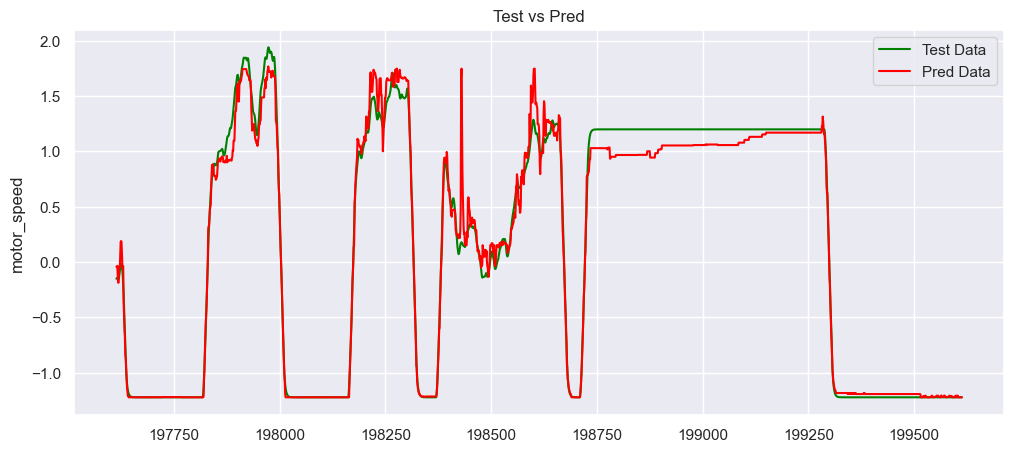

In [141]:
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=ytest[len(xtest)-2000:],label='Test Data',color='green')
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=knn_pred[len(xtest)-2000:],label='Pred Data',color='red')
plt.legend()
plt.title('Test vs Pred')
plt.show()

In [142]:
print(f"Model Score:\
\nR_Squared KNN (train) : {r2_score(ytrain,knn.predict(xtrain))}\
\nR_Squared KNN (test) : {r2_score(ytest,knn_pred)} \
\nMSE (train) : {mean_squared_error(ytrain,knn.predict(xtrain))}\
\nMSE (test) : {mean_squared_error(ytest,knn_pred)}\
\nMAE (train) : {mean_absolute_error(ytrain,knn.predict(xtrain))}\
\nMAE (test) : {mean_absolute_error(ytest,knn_pred)}")

Model Score:
R_Squared KNN (train) : 0.9997152331224651
R_Squared KNN (test) : 0.9941671925489421 
MSE (train) : 0.00027645544424832974
MSE (test) : 0.006222486850443208
MAE (train) : 0.005925419168346156
MAE (test) : 0.039840016060646674


In [143]:
model.append('KNN FULL DATA')
scaled.append(False)
rsqrd_train.append(r2_score(ytrain,knn.predict(xtrain)))
rsqrd_test.append(r2_score(ytest,knn_pred))
mse_train.append(mean_squared_error(ytrain,knn.predict(xtrain)))
mse_test.append(mean_squared_error(ytest,knn_pred))
mae_train.append(mean_absolute_error(ytrain,knn.predict(xtrain)))
mae_test.append(mean_absolute_error(ytest,knn_pred))

# Neural network

In [144]:
import tensorflow as tf
import tensorflow_addons as tfa

In [145]:
input_shape = (xtrain.shape[-1])

In [146]:
x_in = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Dense(16,activation='relu')(x_in)
x_out = tf.keras.layers.Dense(1)(x)
nn = tf.keras.models.Model(inputs=x_in,outputs=x_out)
nn.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.mean_squared_error,
             metrics=tfa.metrics.r_square.RSquare())

In [147]:
es_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=2)

In [148]:
history = nn.fit(xtrain,ytrain,
                    validation_data=(xtest,ytest),
                   batch_size=64,
                   callbacks=[es_cb],
                   epochs=4)

Epoch 1/4
12476/12476 [==============================] - 63s 5ms/step - loss: 0.0158 - r_square: 0.9837 - val_loss: 0.0035 - val_r_square: 0.9967
Epoch 2/4
12476/12476 [==============================] - 63s 5ms/step - loss: 0.0028 - r_square: 0.9971 - val_loss: 0.0015 - val_r_square: 0.9986
Epoch 3/4
12476/12476 [==============================] - 63s 5ms/step - loss: 0.0020 - r_square: 0.9980 - val_loss: 0.0012 - val_r_square: 0.9989
Epoch 4/4
12476/12476 [==============================] - 63s 5ms/step - loss: 0.0018 - r_square: 0.9982 - val_loss: 0.0010 - val_r_square: 0.9990


In [149]:
nn_pred = nn.predict(xtest)
nn_pred = nn_pred.flatten()

6238/6238 [==============================] - 9s 1ms/step


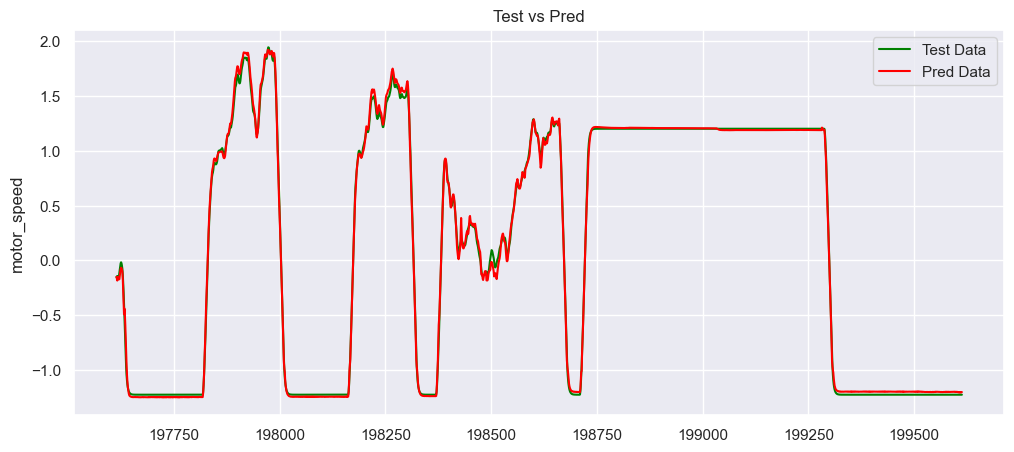

In [150]:
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=ytest[len(xtest)-2000:],label='Test Data',color='green')
sns.lineplot(x=range(len(xtest)-2000,len(xtest)),y=nn_pred[len(xtest)-2000:],label='Pred Data',color='red')
plt.legend()
plt.title('Test vs Pred')
plt.show()

In [151]:
print(f"Model Score:\
\nR_Squared NN (train) : {r2_score(ytrain,nn.predict(xtrain))}\
\nR_Squared NN (test) : {r2_score(ytest,nn_pred)} \
\nMSE (train) : {mean_squared_error(ytrain,nn.predict(xtrain))}\
\nMSE (test) : {mean_squared_error(ytest,nn_pred)}\
\nMAE (train) : {mean_absolute_error(ytrain,nn.predict(xtrain))}\
\nMAE (test) : {mean_absolute_error(ytest,nn_pred)}")

24952/24952 [==============================] - 30s 1ms/step
Model Score:
R_Squared NN (train) : 0.9983718686843027
R_Squared NN (test) : 0.9990165358431065 
MSE (train) : 0.0015806113761265234
MSE (test) : 0.00104916763248239
MAE (train) : 0.022230005232823393
MAE (test) : 0.023350236236071426


In [152]:
model.append('DENSE MODEL FULL DATA')
scaled.append(False)
rsqrd_train.append(r2_score(ytrain,nn.predict(xtrain)))
rsqrd_test.append(r2_score(ytest,nn_pred))
mse_train.append(mean_squared_error(ytrain,nn.predict(xtrain)))
mse_test.append(mean_squared_error(ytest,nn_pred))
mae_train.append(mean_absolute_error(ytrain,nn.predict(xtrain)))
mae_test.append(mean_absolute_error(ytest,nn_pred))

24952/24952 [==============================] - 35s 1ms/step


In [153]:
x_in = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Dense(16,activation='relu')(x_in)
x_out = tf.keras.layers.Dense(1)(x)
nn = tf.keras.models.Model(inputs=x_in,outputs=x_out)
nn.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.mean_squared_error,
             metrics=tfa.metrics.r_square.RSquare())

In [154]:
history = nn.fit(X_fe_df,Y_fe_df,
                   batch_size=64,
                   epochs=4)

Epoch 1/4
15595/15595 [==============================] - 70s 4ms/step - loss: 0.0192 - r_square: 0.9809
Epoch 2/4
15595/15595 [==============================] - 70s 4ms/step - loss: 0.0018 - r_square: 0.9982
Epoch 3/4
15595/15595 [==============================] - 70s 4ms/step - loss: 0.0017 - r_square: 0.9983
Epoch 4/4
15595/15595 [==============================] - 69s 4ms/step - loss: 0.0016 - r_square: 0.9984


In [155]:
stat = pd.DataFrame({
    'Models':model,
    'Scaled':scaled,
    'R_Squared (Train)':rsqrd_train,
    'R_Squared (Test)':rsqrd_test,
    'MSE (Train)':mse_train,
    'MSE (Test)':mse_test,
    'MAE (Train)' : mae_train,
    'MAR (Test)':mae_test
})
stat

,Models,Scaled,R_Squared (Train),R_Squared (Test),MSE (Train),MSE (Test),MAE (Train),MAR (Test)
0,OLS PCA SINGLE SESSION,True,0.929186,0.140154,0.080070,0.866346,0.218212,0.867021
1,OLS FULL DATA,False,0.939591,0.952140,0.060863,0.030561,0.183797,0.115927
2,SGD PCA FULL DATA,True,0.859798,0.878613,0.136110,0.129496,0.289971,0.286078
3,SGD FULL DATA,False,0.923172,0.929220,0.074585,0.075509,0.202839,0.202077
4,RIDGE PCA FULL DATA,True,0.889668,0.901929,0.107112,0.104623,0.258579,0.252355
5,RANDOM FOREST FULL DATA,False,0.999978,0.999969,0.000021,0.000033,0.001261,0.002284
6,CATBOOST FULL DATA,False,0.999718,0.999566,0.000273,0.000463,0.009057,0.012015
7,BAYESIAN RIDGE FULL DATA,False,0.923245,0.928392,0.074514,0.076392,0.200815,0.200297
8,KNN FULL DATA,False,0.999715,0.994167,0.000276,0.006222,0.005925,0.039840
9,DENSE MODEL FULL DATA,False,0.998372,0.999017,0.001581,0.001049,0.022230,0.023350


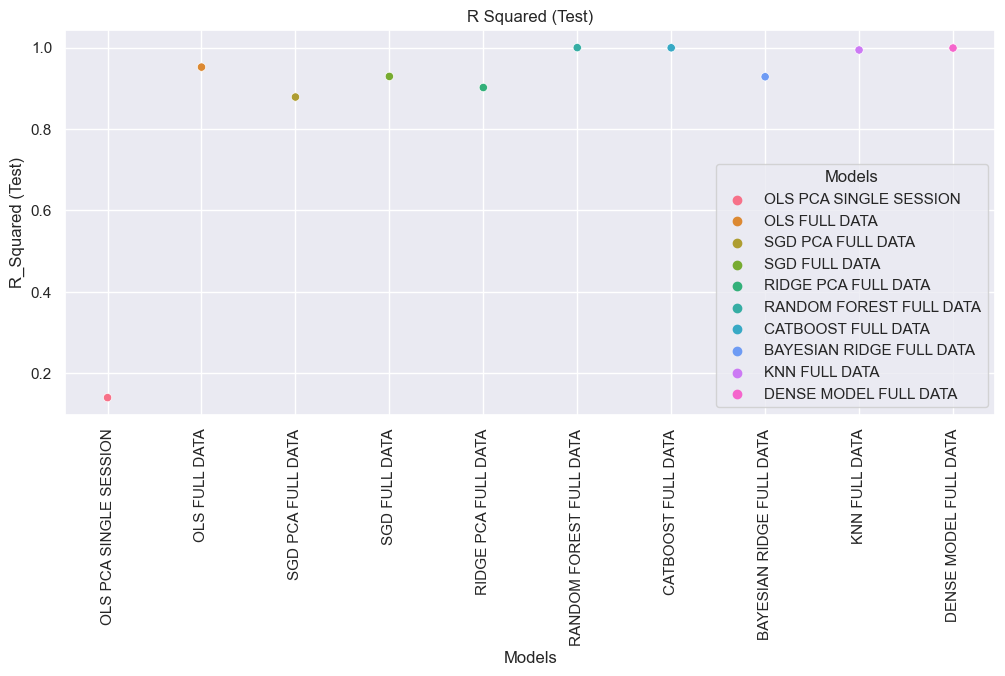

In [162]:
sns.scatterplot(x = stat['Models'],y=stat['R_Squared (Test)'],hue=stat['Models'])
plt.xticks(rotation=90)
plt.title('R Squared (Test)')
plt.show()